In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2, os
import scipy.io as io
import pandas as pd
from scipy import ndimage
from scipy.interpolate import interp1d
from scipy import interpolate
import torch

Text(0.5, 0, 'wavelength [nm]')

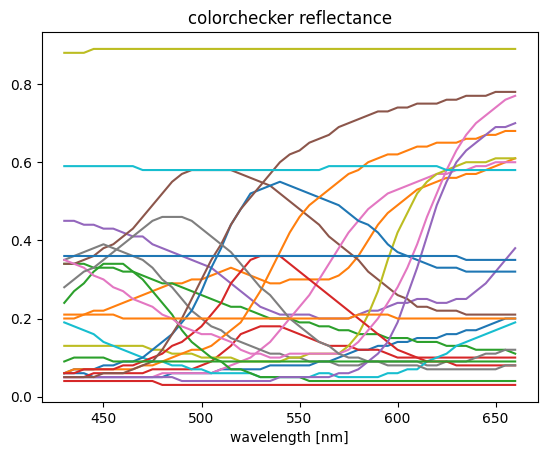

In [2]:
# Replace 'file.csv' with the path to your CSV file
file_path = './dataset/MacbethColorChecker.csv'
# Read the CSV file and store it as a DataFrame
df = pd.read_csv(file_path, header=None, skiprows=2)

# Display the DataFrame
wvls_CC = df.values[1:,0]
wvls_CC = [float(x) for x in wvls_CC] 
ref_CC = df.values[1:,1:-2]

ind_min = 6
ind_max = 61
wvls_CC = wvls_CC[ind_min:ind_max][4:-4]
ref_CC = ref_CC[ind_min:ind_max,:][4:-4]

plt.figure()
plt.plot(wvls_CC, ref_CC)
plt.title('colorchecker reflectance')
plt.xlabel('wavelength [nm]')

In [3]:
# arguments
cam_H, cam_W = 580, 890
wvls = np.arange(430, 670, 10) # 430nm 부터 시작

depth_start = 600
depth_end = 900     
depth_arange = np.arange(depth_start, depth_end + 1, 1)

n_illum = 318
n_patches = 24
n_channel = 3

patch_idx = np.arange(0, 24)
patch_size = 3

# date of datas
date = "1114"

real_data_dir = "./dataset/data/2023%s_real_data/"%date
# opt_param_dir = "./calibration/radiometric_cal/opt_params/opt_param_0915_detach_09500.npy"
# opt_param_dir = "./calibration/radiometric_cal/opt_params/opt_param_1021_detach_09500.npy"

# # 20231114 
# all_patches_center_pts = np.array([[570,208], [570,305],[580,414],
#                                    [647,206], [655,310],[658,416],
#                                    [728,210], [730,310],[736,418]])

# # center points for all patches 20231029
# all_patches_center_pts = np.array([[173,206], [172,242], [170,282], [170,322],[167, 360], [165,400],
#                                     [135,200], [134,238], [130,280], [130,318], [126,358], [126,400],
#                                     [95,200], [90,236], [90,277], [90,314], [87,356], [85,395],
#                                     [53,193], [52,232], [50,273], [48,311], [45,350], [44,395]])

# center points for all patches 20231003
all_patches_center_pts = np.array([[200,160], [300,150], [418,142], [533,133],[651, 129], [770,100],
                                    [200,276], [308,267], [420,260], [537,251], [655,245], [780,237],
                                    [202,386], [310,382], [420,375], [540,375], [660,368], [780,360],
                                    [200,500], [300,490], [420,500], [540,500], [660,490], [790,480]])

# # center points for all patches 20231102
# all_patches_center_pts = np.array([[200,266], [200,300], [200,330], [198,364],[195, 395], [192,430],
#                                     [166,264], [166,300], [163,330], [162,362], [162,395], [158,427],
#                                     [132,265], [130,290], [130,326], [130,360], [130,400], [126,426],
#                                     [100,260], [100,290], [93,326], [94,357], [93,390], [92,425]])

# # center points for all patches 20231022
# all_patches_center_pts = np.array([[293,120], [400,120], [500,120], [608,115],[717,116], [822,115],
#                                     [293,227], [395,218], [507,220], [613,220], [720,220], [830,220],
#                                     [290,320], [400,324], [500,327], [610,328], [720,324], [830,324],
#                                     [288,432], [400,437], [500,436], [615,434], [722,435], [832,428]])

# # 20231031 peaks
# all_patches_center_pts = np.array([[357,195], [358,300],[364,396],
#                                    [568,190], [568,289],[575,387],
#                                    [697,198], [703,294],[705,395]])

# # 20231031(1) peaks
# all_patches_center_pts = np.array([[129,192], [127,300],[124,396],
#                                    [655,195], [655,291],[665,388],
#                                    [778,204], [786,296],[790,398]])

# # 20231031 final peaks
# all_patches_center_pts = np.array([[551,149], [558,254],[558,362]])

# # center points for all patches 20231029 tree
# all_patches_center_pts = np.array([[173,206], [172,242], [170,282], [170,322],[167, 360], [165,400],
#                                     [135,200], [134,238], [130,280], [130,318], [126,358], [126,400],
#                                     [95,200], [90,236], [90,277], [90,314], [87,356], [85,395],
#                                     [53,193], [52,232], [50,273], [48,311], [45,350], [44,395]])

# # 20231031 final peaks
# all_patches_center_pts = np.array([[551,149], [584,254],[550,357]])

# # center points for all patches 20231027
# all_patches_center_pts = np.array([[404,139], [407,171], [409,203], [408,235],[409,267], [409,302],
#                                     [374,140], [374,170], [374,202], [373,233], [374,269], [376,300],
#                                     [339,138], [341,173], [342,203], [341,236], [342,268], [341,301],
#                                     [308,139], [309,172], [308,204], [308,235], [307,267], [310,296]])

### PEF, CRF, DG Efficiency

In [4]:
# # bring initial value of PEF and CRF
# PEF = np.load('./dataset/image_formation/PEF.npy')
# CRF = np.load('./dataset/image_formation/CRF.npy') # from 430nm
# DG_efficiency = np.load('./dataset/image_formation/DG.npy') # from 430nm

PEF = np.load('./dataset/image_formation/PEF_update.npy')
CRF = np.load('./dataset/image_formation/CRF_update.npy') # from 430nm
DG_efficiency = np.load('./dataset/image_formation/DG_update.npy') # from 430nm

# PEF = np.load('./dataset/image_formation/PEF_update_1113.npy')
# CRF = np.load('./dataset/image_formation/CRF_update_1113.npy') # from 430nm
# DG_efficiency = np.load('./dataset/image_formation/DG_update_1113.npy') # from 430nm

new_wvls = torch.linspace(430*1e-9, 660*1e-9, 47) # 400 ~ 680 까지 10nm 간격으로

(<AxesSubplot:title={'center':'5nm interpolated DG Efficiency'}>,
 Text(0.5, 1.0, '5nm interpolated DG Efficiency'))

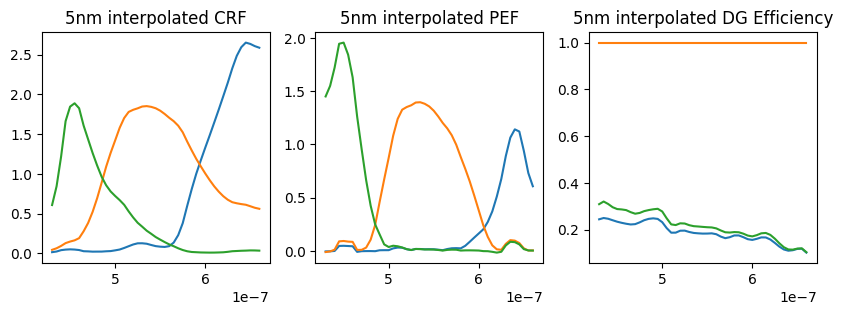

In [5]:
plt.figure(figsize=(10,3))
plt.subplot(131), plt.plot(new_wvls, CRF), plt.title('5nm interpolated CRF')
plt.subplot(132), plt.plot(new_wvls, PEF), plt.title('5nm interpolated PEF')
plt.subplot(133), plt.plot(new_wvls, DG_efficiency.T), plt.title('5nm interpolated DG Efficiency')

### Vis

In [6]:
# fig, ax = plt.subplots()
# # Erasing y-axis and x-axis labels
# ax.set_xticklabels([])
# ax.set_yticklabels([])

# # Setting ticks direction to inward
# ax.tick_params(axis='x', direction='in')
# ax.tick_params(axis='y', direction='in')

# ax.plot(new_wvls, CRF[:,0].T / CRF.max(), c = 'r')#, plt.title('5nm interpolated CRF')
# ax.plot(new_wvls, CRF[:,1].T/ CRF.max(), c = 'g')#, plt.title('5nm interpolated CRF')
# ax.plot(new_wvls, CRF[:,2].T/ CRF.max(), c = 'b')#, plt.title('5nm interpolated CRF')

# ax.plot(new_wvls, PEF[:,0]/ PEF.max(), c = 'r', linestyle = '--')#, plt.title('5nm interpolated PEF')
# ax.plot(new_wvls, PEF[:,1]/ PEF.max(), c = 'g', linestyle = '--')#, plt.title('5nm interpolated PEF')
# ax.plot(new_wvls, PEF[:,2]/ PEF.max(), c = 'b', linestyle = '--')#, plt.title('5nm interpolated PEF')

# plt.grid(linestyle = '--', c = 'whitesmoke')

# plt.savefig('opt_crf_pef.svg')
# # plt.plot(wvls, dg_intensity), plt.title('5nm interpolated DG Efficiency')
# # plt.savefig('diffraction efficiency')

In [7]:
# scalar = np.ones(shape=(47,))
# scalar[0:3] = 1.8
# scalar[3] = 1.5
# scalar[4] = 1.2
# scalar[5:12] = 0.75

scalar = np.ones(shape=(47,))
scalar[0:3] = 1.9
scalar[3] = 1.9
scalar[4:6] = 1.5
scalar[6:9] = 1.3
scalar[9:11] = 1.5
scalar[11:15] = 1.6
scalar[15:16] = 1.5
scalar[16:18] = 1.2

In [8]:
# plt.ylim([0,1])
# plt.plot(new_wvls, DG_efficiency[0], c = 'red'), plt.title('5nm interpolated DG Efficiency')
# plt.plot(new_wvls, DG_efficiency[2],  c = 'blue'), plt.title('5nm interpolated DG Efficiency')
# # dg_scalar = 1+1*(DG_efficiency[2]-DG_efficiency[0])
# plt.plot(new_wvls, dg_scalar,  c = 'green'), plt.title('5nm interpolated DG Efficiency')
# plt.plot(new_wvls, DG_efficiency[2]*scalar,  c = 'yellow'), plt.title('5nm interpolated DG Efficiency')

#### Optimization

In [9]:
# # bring initial value of PEF and CRF
# PEF = np.load('./dataset/image_formation/CRF_proj.npy')
# map_scale = interp1d([PEF.min(), PEF.max()], [0.,1])
# PEF = map_scale(PEF).astype(np.float32)
# PEF = PEF[3:27] # from 430nm

# CRF = np.load('./dataset/image_formation/CRF_230828.npy')[:,:] # from 430nm

# dg_intensity = np.load('./dataset/image_formation/dg_efficiency.npy')[1:] # from 430nm

In [10]:
# def cubic_interpolation(x_new, x_points, y_points, n):
#     tck = interpolate.splrep(x_points, y_points, k=n)   # Estimate the polynomial of nth degree by using x_points and y_points
#     y_new = interpolate.splev(x_new, tck)
#     return y_new

# # wvls from 430 ~ 660 without 630nm
# wvls = np.arange(430, 670, 10)
# wvls = torch.tensor(wvls)*1e-9
# new_wvls = torch.linspace(430*1e-9, 660*1e-9, 47) # 400 ~ 680 까지 10nm 간격으로

In [11]:
# # interpolated CRF for 5nm
# CRF_R = cubic_interpolation(new_wvls, wvls, CRF[:,0], 4)
# CRF_G = cubic_interpolation(new_wvls, wvls, CRF[:,1], 4)
# CRF_B = cubic_interpolation(new_wvls, wvls, CRF[:,2], 4)

# # interpolated PEF for 5nm
# PEF_R = cubic_interpolation(new_wvls, wvls, PEF[:,0], 4)
# PEF_G = cubic_interpolation(new_wvls, wvls, PEF[:,1], 4)
# PEF_B = cubic_interpolation(new_wvls, wvls, PEF[:,2], 4)

# # interpolated CRF for 5nm
# dg_efficiency_R = cubic_interpolation(new_wvls, wvls, dg_intensity[:,0], 4)
# dg_efficiency_G = cubic_interpolation(new_wvls, wvls, dg_intensity[:,1], 4)
# dg_efficiency_B = cubic_interpolation(new_wvls, wvls, dg_intensity[:,2], 4)

In [12]:
# CRF_intp = np.stack((CRF_R, CRF_G, CRF_B))
# PEF_intp = np.stack((PEF_R, PEF_G, PEF_B))
# dg_intensity_intp = np.stack((dg_efficiency_R, dg_efficiency_G, dg_efficiency_B))

In [13]:
# # bring optimized parameters
# opt_param_final = np.load(opt_param_dir)

# # update parameter
# CRF = CRF_intp.T * opt_param_final[:,3:]
# # CRF = CRF_intp.T * opt_param_final[:,3:-2]

# PEF = PEF_intp.T * opt_param_final[:,:3]
# dg_intensity_intp[2] = dg_intensity_intp[2] #* opt_param_final[:,-1]
# dg_intensity_intp[0] = dg_intensity_intp[0] #* opt_param_final[:,-2]
# DG_efficiency = dg_intensity_intp

In [14]:
# fig, ax = plt.subplots()
# # Erasing y-axis and x-axis labels
# ax.set_xticklabels([])
# ax.set_yticklabels([])

# # Setting ticks direction to inward
# ax.tick_params(axis='x', direction='in')
# ax.tick_params(axis='y', direction='in')

# ax.plot(wvls, CRF[0,1:].T, c = 'r')#, plt.title('5nm interpolated CRF')
# ax.plot(wvls, CRF[1,1:].T, c = 'g')#, plt.title('5nm interpolated CRF')
# ax.plot(wvls, CRF[2,1:].T, c = 'b')#, plt.title('5nm interpolated CRF')

# ax.plot(wvls, PEF[:,0], c = 'r', linestyle = '--')#, plt.title('5nm interpolated PEF')
# ax.plot(wvls, PEF[:,1], c = 'g', linestyle = '--')#, plt.title('5nm interpolated PEF')
# ax.plot(wvls, PEF[:,2], c = 'b', linestyle = '--')#, plt.title('5nm interpolated PEF')

# plt.grid(linestyle = '--', c = 'whitesmoke')

# plt.savefig('crf_pef.svg')
# # plt.plot(wvls, dg_intensity), plt.title('5nm interpolated DG Efficiency')
# # plt.savefig('diffraction efficiency')

In [15]:
# CRF[-3,0] = 1.3
# CRF[-2,0] = 0.5
# CRF[-1,0] = 0.1
# PEF[0,2] = 0.5
# PEF[1,2] = 0.8
# PEF[2,2] = 1.0

In [16]:
# plt.figure(figsize=(10,3))
# plt.subplot(131), plt.plot(new_wvls, CRF), plt.plot(new_wvls[::2], CRF[::2]), plt.title('5nm interpolated CRF')
# plt.subplot(132), plt.plot(new_wvls, PEF), plt.title('5nm interpolated PEF')
# plt.subplot(133), plt.plot(new_wvls, DG_efficiency.T), plt.title('5nm interpolated DG Efficiency')

In [17]:
# fig, ax = plt.subplots()
# plt.ylim([0,1.05])
# ax.plot(new_wvls*1E9, DG_efficiency.T[:,0], linewidth = 2.5, c = 'red')
# ax.plot(new_wvls*1E9, DG_efficiency.T[:,1], linewidth = 2.5, c = 'black')
# ax.plot(new_wvls*1E9, DG_efficiency.T[:,2], linewidth = 2.5, c = 'blue')
# ax.tick_params(axis='both', which='major', labelsize=15, direction = 'in')
# plt.xlabel('wavelengths')
# plt.grid(linestyle = '--', c = 'whitesmoke')
# plt.ylabel('illumination index')
# plt.savefig('./dg.svg')

In [18]:
# np.save('CRF.npy', CRF)
# np.save('PEF.npy', PEF)
# np.save('DG.npy', DG_efficiency)

In [19]:
# np.load('new_CRF.npy').shape

In [20]:
# from scipy.interpolate import make_interp_spline 
 
# # Dataset
# x = new_wvls
# y = CRF
 
# X_Y_Spline = make_interp_spline(x, y)
 
# # Returns evenly spaced numbers
# # over a specified interval.
# X_ = np.linspace(x.min(), x.max(), 500)
# Y_ = X_Y_Spline(X_)

# # # Projector
# # # Dataset
# # z = new_wvls
# # t = PEF
 
# # Z_T_Spline = make_interp_spline(z, t)
 
# # # Returns evenly spaced numbers
# # # over a specified interval.
# # Z_ = np.linspace(z.min(), z.max(), 500)
# # T_ = Z_T_Spline(Z_)

# # Plotting the Graph
# fig, ax = plt.subplots()

# map_scale1 = interp1d([PEF.min(), PEF.max()], [0.,1.])
# PEF_map = torch.tensor(map_scale1(PEF).astype(np.float32))

# # map_scale1 = interp1d([T_.min(), T_.max()], [0.,1.])
# # PEF_map = torch.tensor(map_scale1(T_).astype(np.float32))

# map_scale2 = interp1d([Y_.min(), Y_.max()], [0.,1.])
# CRF_map = torch.tensor(map_scale2(Y_).astype(np.float32))

# plt.plot(X_, CRF_map[:,0],color = 'red', ls = '-', label = 'Camera R')
# plt.plot(X_, CRF_map[:,1],color = 'green', ls = '-',label = 'Camera G')
# plt.plot(X_, CRF_map[:,2],color = 'blue', ls = '-',label = 'Camera B')

# plt.plot(new_wvls, PEF_map[:,0],color = 'red', ls = '--',label = 'Projector R')
# plt.plot(new_wvls, PEF_map[:,1],color = 'green', ls = '--',label = 'Projector G')
# plt.plot(new_wvls, PEF_map[:,2],color = 'blue', ls = '--',label = 'Projector B')

# # plt.plot(Z_, PEF_map[:,0],color = 'red', ls = '-',label = 'Projector R')
# # plt.plot(Z_, PEF_map[:,1],color = 'green', ls = '-',label = 'Projector G')
# # plt.plot(Z_, PEF_map[:,2],color = 'blue', ls = '-',label = 'Projector B')

# plt.xlabel("wavelength", fontsize=18)
# plt.ylabel("Q.E", fontsize=18)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.71), fontsize="13", frameon = False, labelspacing = 1)
# plt.grid(linestyle = '--', c = 'whitesmoke')
# ax.tick_params(axis='both', which='major', labelsize=15, direction = 'in')
# plt.savefig('opt_crf_pef.svg')
# plt.show()
# # plt.savefig('opt_crf_pef.svg')
# # crf, pef max 1로
# # 검정색 실선, 점선 

# # -1 ,1 order선 표시해서


### Bring HDR data

In [21]:
# # load original hdr data
# hdr_imgs = np.load('./hdr_step5_1003.npy') / 65535
hdr_imgs = np.load('./hdr_step5_1114.npy') / 65535

# median filter
hdr_imgs_filtered_R = np.array([ndimage.median_filter(image[:,:,0], size=4) for image in hdr_imgs])
hdr_imgs_filtered_G = np.array([ndimage.median_filter(image[:,:,1], size=4) for image in hdr_imgs])
hdr_imgs_filtered_B = np.array([ndimage.median_filter(image[:,:,2], size=4) for image in hdr_imgs])

hdr_imgs_filtered = np.stack((hdr_imgs_filtered_R, hdr_imgs_filtered_G, hdr_imgs_filtered_B), axis = 3)

# save
# np.save('hdr_imgs_filtered.npy', hdr_imgs_filtered)

# load
# hdr_imgs = np.load('hdr_imgs_filtered.npy') # 318, 580, 890, 3

hdr_imgs = hdr_imgs_filtered

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


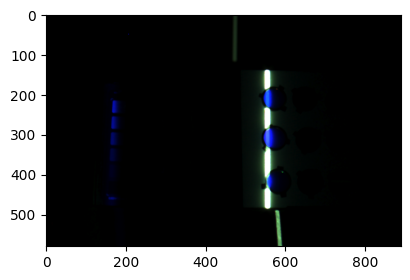

In [22]:
plt.figure(figsize=(5,3))
plt.imshow(hdr_imgs[200])

### Bring depth

In [23]:
if date == "1003":
    depth = np.load(os.path.join(real_data_dir,'2023%s_color_checker.npy'%date))[:,:,2]*1e+3
else:
    depth = np.load(os.path.join(real_data_dir,'2023%s_depth.npy'%date))[:,:,2]*1e+3

In [24]:
depth[depth>900] = 0

(<matplotlib.image.AxesImage at 0x17a87093848>,
 <matplotlib.colorbar.Colorbar at 0x17a870d4608>)

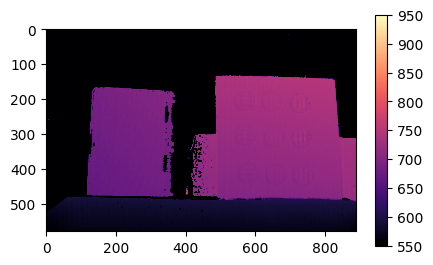

In [25]:
plt.figure(figsize=(5,3))
plt.imshow(depth, vmin=550, vmax = 950, cmap='magma'), plt.colorbar()

In [26]:
# median filter
# depth_filtered = np.array([ndimage.median_filter(depth, size=7)])

In [27]:
depth = np.round(depth).reshape(cam_H* cam_W).astype(np.int16)

### Depth dependent peak illumination index

In [28]:
first_illum_idx = np.load(('./dataset/image_formation/20231007/npy_data/first_illum_idx_final_transp_test_2.npy'))
Mask = np.load('./dataset/image_formation/20231007/npy_data/Mask.npy')

In [29]:
first_illum_idx = first_illum_idx.reshape(len(depth_arange), len(new_wvls), cam_H*cam_W)

In [30]:
first_illum_idx_reshape = first_illum_idx.reshape(301, 47, 580, 890)

In [31]:
# Mask mask

# Mask = np.ones_like(first_illum_idx)

# for i in range(first_illum_idx.shape[0]):
#     for j in range(first_illum_idx.shape[2]):
#             # Get a [47,] array
#             sub_array = first_illum_idx[i, :, j]
            
#             # Find unique elements and their counts
#             unique_elements, counts = np.unique(sub_array, return_counts=True)
            
#             # Identify the repeated elements
#             repeated_elements = unique_elements[counts > 1]
            
#             # Find and print the indices of the repeated elements
#             for element in repeated_elements:
#                 indices = np.where(sub_array == element)[0]
#                 if np.any(indices < 34):
#                     print('error, i, j')
#                 Mask[i,indices[1:],j] = 0

### Get Mask for uncaptured wavelengths

In [32]:
first_illum_idx[first_illum_idx >= 318] = 317
first_illum_idx[first_illum_idx < 0 ] = 0

### zero order illumination index

In [33]:
# zero_illum_idx = np.zeros(shape=(cam_H * cam_W))
# hdr_imgs_reshape = hdr_imgs.reshape(n_illum, cam_H*cam_W, 3)

# for i in range(cam_H*cam_W):
#     max_idx = np.argmax(hdr_imgs_reshape[:,i].mean(axis = 1))
#     zero_illum_idx[i] = max_idx

# zero_illum_idx = np.round(zero_illum_idx)

In [34]:
zero_illum_idx_wo_depth = np.zeros(shape=(cam_H * cam_W))
hdr_imgs_reshape = hdr_imgs.reshape(n_illum, cam_H*cam_W, 3)

for i in range(cam_H*cam_W):
    max_idx = np.argmax(hdr_imgs_reshape[:,i].mean(axis = 1))
    zero_illum_idx_wo_depth[i] = max_idx

zero_illum_idx_wo_depth = np.round(zero_illum_idx_wo_depth)
zero_illum_idx = np.repeat(zero_illum_idx_wo_depth.reshape(1, 1, cam_H*cam_W), len(depth_arange), axis=0)

print(zero_illum_idx.shape)

(301, 1, 516200)


In [35]:
# Choose valid idx
zero_real_img_illum_idx = np.zeros(shape=(1, cam_H*cam_W))
for i in range(cam_H*cam_W):
    if (depth[i] < 600) or (depth[i] > 900):
        depth[i] = 600
    depth_idx = np.where(depth_arange == depth[i])[0][0]
    zero_real_img_illum_idx[:,i] = zero_illum_idx[depth_idx, :, i]

zero_real_img_illum_idx = zero_real_img_illum_idx.astype(np.int16).reshape(1, cam_H, cam_W)
zero_real_img_illum_idx_final = np.stack((zero_real_img_illum_idx, zero_real_img_illum_idx, zero_real_img_illum_idx), axis = 3)

print(zero_real_img_illum_idx_final.shape)

(1, 580, 890, 3)


### Get valid first order illumination idx

In [36]:
# Choose valid idx
first_real_img_illum_idx = np.zeros(shape=(len(new_wvls), cam_H*cam_W))
mask_idx = np.zeros(shape=(len(new_wvls), cam_H*cam_W))
for i in range(cam_H*cam_W):
        if (depth[i] < 600) or (depth[i] > 900):
                depth[i] = 600
        depth_idx = np.where(depth_arange == depth[i])[0][0]
        first_real_img_illum_idx[:,i]= first_illum_idx[depth_idx,:,i]
        mask_idx[:,i] = Mask[depth_idx,:,i]
first_real_img_illum_idx = first_real_img_illum_idx.astype(np.int16).reshape(len(new_wvls), cam_H, cam_W)
first_real_img_illum_idx_final = np.stack((first_real_img_illum_idx, first_real_img_illum_idx, first_real_img_illum_idx), axis = 3)
print(first_real_img_illum_idx_final.shape)

(47, 580, 890, 3)


### Diffraction grating efficiency

In [37]:
first_real_img_illum_idx_reshape = first_real_img_illum_idx.reshape(len(new_wvls), cam_H*cam_W)

# DG efficiency for all pixels
DG_efficiency_image_first = np.zeros(shape=(cam_H * cam_W, len(new_wvls)))
DG_efficiency_image_zero = np.ones(shape=(cam_H * cam_W, len(new_wvls))) # * (max(DG_efficiency[0].sum(), DG_efficiency[2].sum()) / 47)

dg_scalar = 1+0.5*(DG_efficiency[2]-DG_efficiency[0])

for i in range(cam_H * cam_W):
    if zero_illum_idx_wo_depth[i] > first_real_img_illum_idx_reshape[0,i]: # 430nm # -1 order
        DG_efficiency_image_first[i,:] =  DG_efficiency[0]
    elif zero_illum_idx_wo_depth[i] < first_real_img_illum_idx_reshape[0,i]: # +1 order
        DG_efficiency_image_first[i,:] =  DG_efficiency[2] #* scalar #dg_scalar
    else: # else
        DG_efficiency_image_first[i,:] = 0

In [38]:
white_pattern = np.ones(shape = (1, 3)) * 0.8
white_pattern_hyp = white_pattern @ PEF.T

x, y, z = np.meshgrid(np.arange(580), np.arange(890), np.arange(3), indexing='ij')

GT_I_RGB_FIRST = hdr_imgs[first_real_img_illum_idx_final, x, y, z].transpose(1, 2, 0, 3)   
GT_I_RGB_ZERO =  hdr_imgs[zero_real_img_illum_idx_final, x, y, z].transpose(1, 2, 0, 3)

In [39]:
SIMULATION

NameError: name 'SIMULATION' is not defined

### Simulation

#### Peak

In [ ]:
# peak_wvl = np.array([570, 560, 550])
# peak_wvl = np.array([450, 560, 590, 540, 600, 580, 550, 460])
peak_wvl = np.array([470, 460, 450, 570, 560, 550, 620, 610, 600])

In [ ]:
# 20231114 
all_patches_center_pts = np.array([[570,208], [570,305],[580,414],
                                   [647,206], [655,310],[658,416],
                                   [723,201], [720,316],[741,418]]) # 728 210

# # 20231114 
# all_patches_center_pts = np.array([[570,208], [570,305],[580,414],
#                                    [647,206], [655,310],[658,416],
#                                    [728,210], [730,310],[736,418]])

In [ ]:
for i in range(len(all_patches_center_pts)):
# for i in range(len(pts)):
    argmax_idx = np.argmax(GT_I_RGB_FIRST[all_patches_center_pts[i,1],all_patches_center_pts[i,0]].mean(axis = 1))
    # argmax_idx = np.argmax(GT_I_RGB_FIRST[pts[i,1],pts[i,0]].mean(axis = 1))

    # if argmax_idx == 38:
        # print(pts[i])
    print('%dnm'%peak_wvl[i], new_wvls[argmax_idx]*1e9)
        # print('620nm', new_wvls[argmax_idx]*1e9)

470nm tensor(455.)
460nm tensor(645.)
450nm tensor(460.)
570nm tensor(460.)
560nm tensor(645.)
550nm tensor(460.)
620nm tensor(535.)
610nm tensor(460.)
600nm tensor(460.)


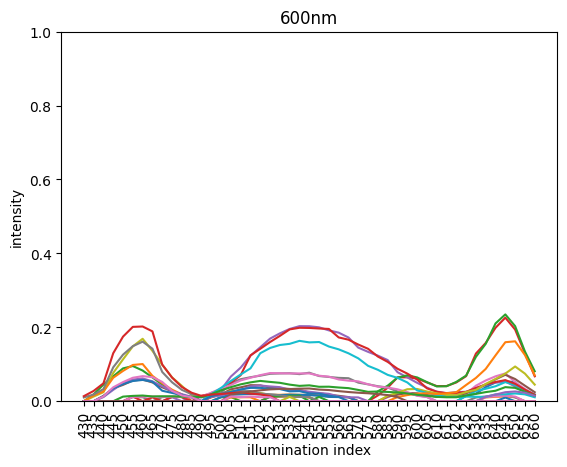

In [ ]:
DG_efficiency_image_reshape = DG_efficiency_image_first.reshape(580, 890, 47)

for i in range(len(all_patches_center_pts)):
        plt.ylim([0,1])
        plt.xlabel('illumination index')
        plt.ylabel('intensity')        
        dg = DG_efficiency_image_reshape[all_patches_center_pts[i,1],all_patches_center_pts[i,0]][:,np.newaxis]
       
        plt.plot(new_wvls*1e9,GT_I_RGB_FIRST[all_patches_center_pts[i,1],all_patches_center_pts[i,0]], label = "Real captured")
        plt.xticks(new_wvls*1e9)
        plt.xticks(rotation=90)
        # plt.legend()
        plt.title('%02dnm'%peak_wvl[i])

#### PDG

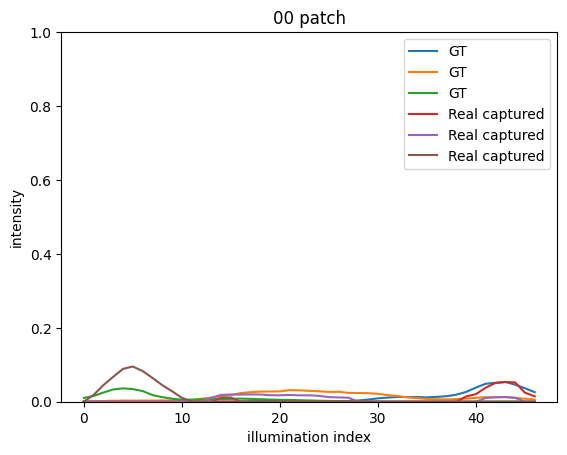

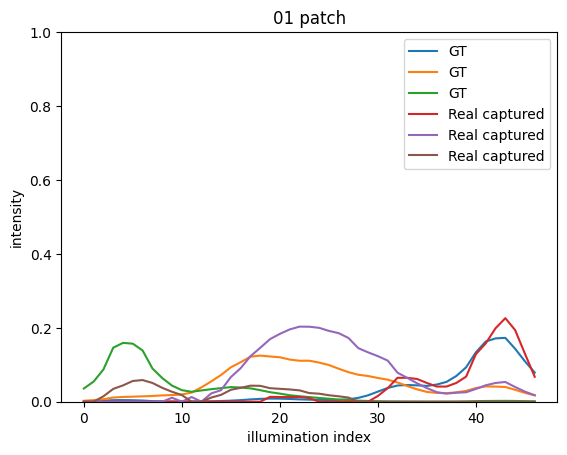

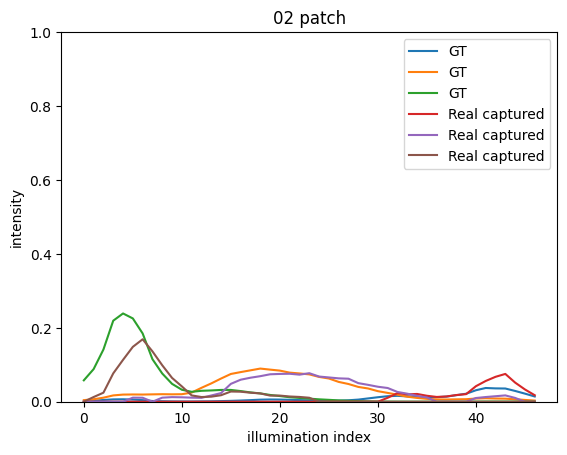

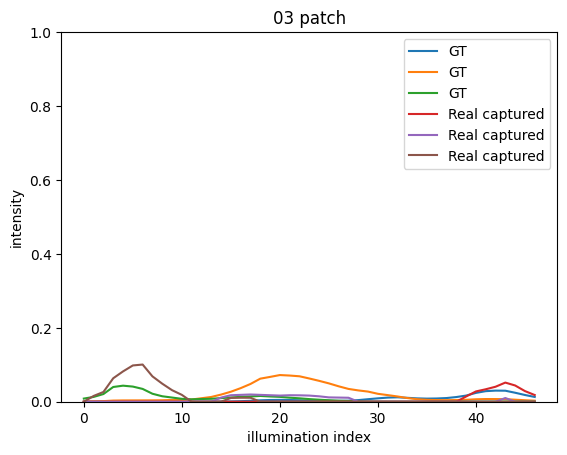

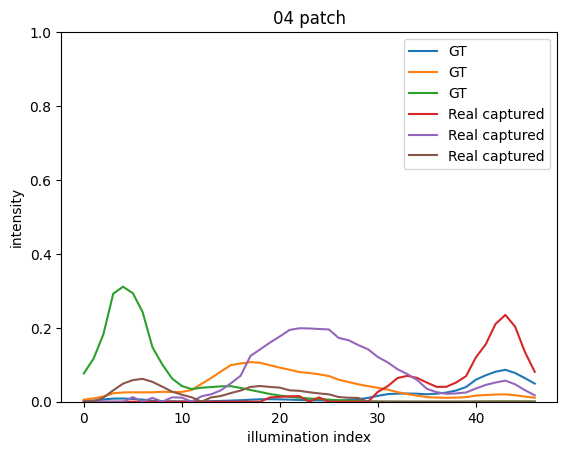

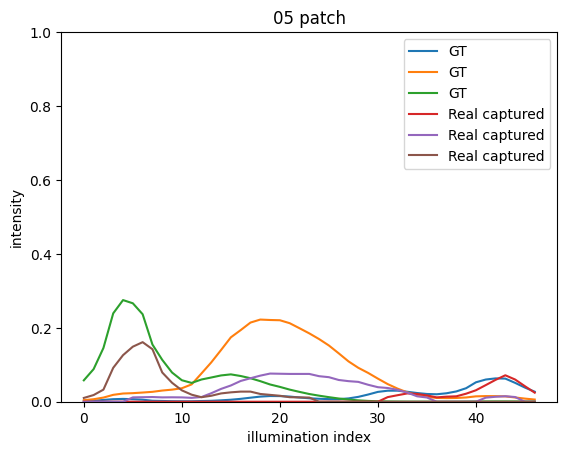

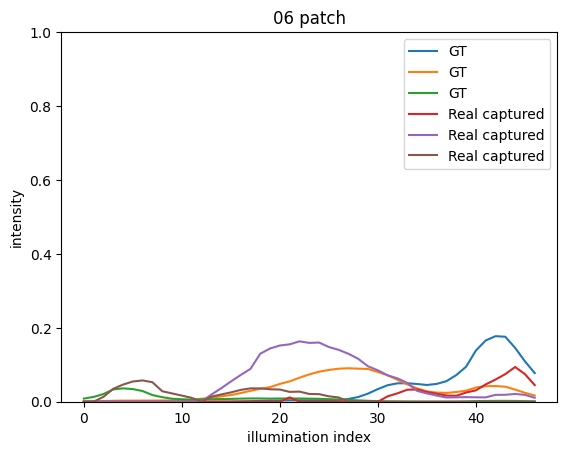

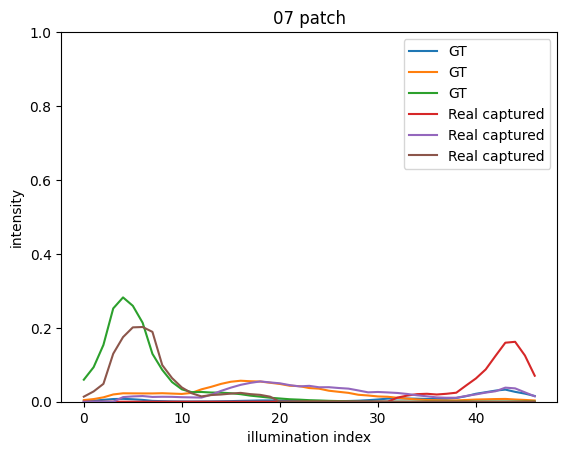

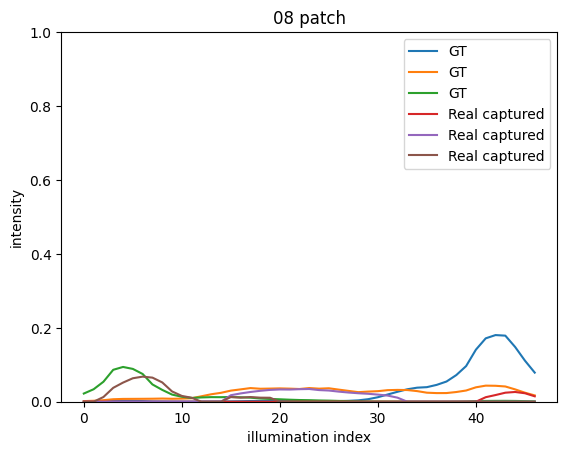

In [ ]:
DG_efficiency_image_reshape = DG_efficiency_image_first.reshape(580, 890, 47)

for i in range(len(all_patches_center_pts)):
        plt.figure()
        plt.ylim([0,1])
        plt.xlabel('illumination index')
        plt.ylabel('intensity')
        
        dg = DG_efficiency_image_reshape[all_patches_center_pts[i,1],all_patches_center_pts[i,0]][:,np.newaxis]
        
        plt.plot((ref_CC[:,i][:,np.newaxis] * white_pattern_hyp.transpose(1,0) * dg) * CRF, label= 'GT')
        
        # plt.plot(GT_I_RGB_FIRST[all_patches_center_pts[i,1],all_patches_center_pts[i,0]-30 + j], label = "Real captured")
        plt.plot(GT_I_RGB_FIRST[all_patches_center_pts[i,1],all_patches_center_pts[i,0]], label = "Real captured")

        plt.legend()
        plt.title('%02d patch'%i)

## Hyp Recon

### SVD csj

In [ ]:
# n_lambda = 47
# weight_D = 4
# device = 'cuda:0'
# x, y, z = np.meshgrid(np.arange(580), np.arange(890), np.arange(3), indexing='ij')

# # D matrix
# i_mat = np.eye(n_lambda)
# diagonal_indices = np.diag_indices(i_mat.shape[0])
# new_diagonal_indices_col = np.copy(diagonal_indices[1])
# new_diagonal_indices_col[:-1] = diagonal_indices[1][:-1] + 1
# i_mat[(diagonal_indices[0], new_diagonal_indices_col)] = -1
# D = i_mat
# D[-1] = i_mat[-2]

# D = torch.tensor(D, device=device)

# # to tensor, device
# CRF = torch.tensor(CRF, device=device).type(torch.float32)
# PEF = torch.tensor(PEF, device=device).type(torch.float32)
# hdr_imgs_t = torch.tensor(hdr_imgs, device=device)
# first_illum_idx_final_transp_t = torch.tensor(first_real_img_illum_idx_final, device=device)
# DG_efficiency_image_t = torch.tensor(DG_efficiency_image_first.reshape(cam_H*cam_W, -1), device= device) # H x W, wvls

# # pattern
# white_patt = torch.ones(size = (cam_H * cam_W, 3), device=device) * 0.8
# white_patt_hyp = white_patt @ PEF.T
# white_patt_hyp = white_patt_hyp.squeeze()

# CRF_sum = torch.tensor(CRF, device=device).sum(axis = 1)

# total_hyp_ref = []

# # summation of Image RGB channel
# I_C = hdr_imgs_t[first_illum_idx_final_transp_t.long(), x, y, z].permute(1, 2, 0, 3).sum(axis = 3).reshape(-1, n_lambda, 1) # H x W, wvls, 1
# A = (CRF_sum.unsqueeze(dim = 0) * white_patt_hyp * DG_efficiency_image_t).unsqueeze(dim =2) # HxW, wvls, 1

In [ ]:
n_lambda = 47
weight_D = 4
weight_first = 1
weight_zero = 0.00
device = 'cuda:0'
x, y, z = np.meshgrid(np.arange(580), np.arange(890), np.arange(3), indexing='ij')

# D matrix
i_mat = np.eye(n_lambda)
diagonal_indices = np.diag_indices(i_mat.shape[0])
new_diagonal_indices_col = np.copy(diagonal_indices[1])
new_diagonal_indices_col[:-1] = diagonal_indices[1][:-1] + 1
i_mat[(diagonal_indices[0], new_diagonal_indices_col)] = -1
D = i_mat
D[-1] = i_mat[-2]

D = torch.tensor(D, device=device)

# to tensor, device
CRF = torch.tensor(CRF, device=device).type(torch.float32)
PEF = torch.tensor(PEF, device=device).type(torch.float32)
hdr_imgs_t = torch.tensor(hdr_imgs, device=device)
first_illum_idx_final_transp_t = torch.tensor(first_real_img_illum_idx_final, device=device)
DG_efficiency_first_dev = torch.tensor(DG_efficiency_image_first.reshape(cam_H*cam_W, -1), device= device) # H x W, wvls
DG_efficiency_zero_dev = torch.tensor(DG_efficiency_image_zero.reshape(cam_H*cam_W, -1), device=device)

# pattern
white_patt = torch.ones(size = (cam_H * cam_W, 3), device=device) * 0.8
white_patt_hyp = white_patt @ PEF.T
white_patt_hyp = white_patt_hyp.squeeze()

CRF_sum = torch.tensor(CRF, device=device).sum(axis = 1)

total_hyp_ref = []

mask = torch.tensor(mask_idx.T, device=device).reshape(cam_H*cam_W, 47, 1)

# summation of Image RGB channel
I_C_first = hdr_imgs_t[first_illum_idx_final_transp_t.long(), x, y, z].permute(1, 2, 0, 3).sum(axis = 3).reshape(-1, n_lambda, 1) * weight_first # H x W, wvls, 1
I_C_zero =  hdr_imgs[zero_real_img_illum_idx_final, x, y, z].transpose(1, 2, 0, 3) * weight_zero
I_C_zero = torch.tensor(I_C_zero.sum(axis=3), device=device) / 1.7

A_first = (CRF_sum.unsqueeze(dim = 0) * white_patt_hyp * DG_efficiency_first_dev).unsqueeze(dim =2) # HxW, wvls, 1
A_zero = (CRF_sum.unsqueeze(dim = 0) * white_patt_hyp * DG_efficiency_zero_dev).unsqueeze(dim =2) # HxW, wvls, 1


A_first_diag = torch.diag_embed((A_first*A_first).squeeze()) * weight_first
A_zero_diag = torch.diag_embed((A_zero*A_zero).squeeze()) * weight_zero

weight_D_DT = (weight_D*D.T@D).unsqueeze(dim = 0)

Left = A_first_diag + A_zero_diag + weight_D_DT
Right = A_first*I_C_first.reshape(cam_H*cam_W, n_lambda,1) + A_zero*I_C_zero.reshape(cam_H*cam_W, 1,1)

csj_x = torch.linalg.solve(Left, Right)

total_hyp_ref = csj_x.squeeze()
total_hyp_ref = total_hyp_ref.reshape(cam_H, cam_W, n_lambda)


c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


OutOfMemoryError: CUDA out of memory. Tried to allocate 8.50 GiB (GPU 0; 12.00 GiB total capacity; 33.68 GiB already allocated; 0 bytes free; 42.40 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# A_zero.shape

In [ ]:
# A_diag = torch.diag_embed((A*A).squeeze())

# weight_D_DT = (weight_D*D.T@D).unsqueeze(dim = 0)

# csj_x = torch.linalg.solve(A_diag + weight_D_DT, A*I_C.reshape(cam_H*cam_W, n_lambda,1))

# total_hyp_ref = csj_x.squeeze()
# total_hyp_ref = total_hyp_ref.reshape(cam_H, cam_W, n_lambda)

In [ ]:
total_hyp_ref = csj_x.squeeze()
total_hyp_ref = total_hyp_ref.reshape(cam_H, cam_W, n_lambda)
total_hyp_ref = total_hyp_ref.detach().cpu().numpy()

In [ ]:
# # 4x6 격자 배열의 subplot을 생성
# fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(12, 8))
# new_reflectance = opt_param_detach.reshape(cam_H, cam_W, 47)#.detach().cpu().numpy()/20

# # 24개의 그래프 생성 (예시로 랜덤 데이터 사용)
# import numpy as np

# # for i in range(24):
# for i in range(4):
#     for j in range(6):
#         # 각 subplot에 데이터 생성
#     axes[i//6, i%6].set_ylim([0,1])
#         # data = np.random.random((10,))  # 예시로 10개의 랜덤 데이터 생성
#     axes[i//6, i%6].plot(opt_param_detach[all_patches_center_pts[i,1],all_patches_center_pts[i,0]], label='estimated')
#     axes[i//6, i%6].plot(ref_CC[:,i], label='GT')
#     axes[i//6, i%6].set_title(f'Plot {i + 1}')  # 그래프 제목 설정

# # subplot 간의 간격 조정
# plt.tight_layout()

# # 그래프 표시
# plt.show()

In [ ]:
# wvl_title = (new_wvls*1e9).to(torch.int16)

In [ ]:
# wvl_title = (new_wvls*1e9).to(torch.int16)
# for i in range(len(new_wvls)):
#     plt.imshow(total_hyp_ref[:,:,i], vmin = 0, vmax=1), plt.colorbar(), plt.title('%fnm'%wvl_title[i])
#     plt.show()

### SVD

In [ ]:
# n_lambda = 47
# weight_D = 0.5
# device = 'cuda:0'
# x, y, z = np.meshgrid(np.arange(580), np.arange(890), np.arange(3), indexing='ij')

# # D matrix
# i_mat = np.eye(n_lambda)
# diagonal_indices = np.diag_indices(i_mat.shape[0])
# new_diagonal_indices_col = np.copy(diagonal_indices[1])
# new_diagonal_indices_col[:-1] = diagonal_indices[1][:-1] + 1
# i_mat[(diagonal_indices[0], new_diagonal_indices_col)] = -1
# D = i_mat
# D[-1] = i_mat[-2]

# D = torch.tensor(D, device=device)

# # to tensor, device
# CRF = torch.tensor(CRF, device=device).type(torch.float32)
# PEF = torch.tensor(PEF, device=device).type(torch.float32)
# hdr_imgs_t = torch.tensor(hdr_imgs, device=device)
# first_illum_idx_final_transp_t = torch.tensor(real_img_illum_idx_final, device=device)
# DG_efficiency_image_t = torch.tensor(DG_efficiency_image.reshape(cam_H*cam_W, -1), device= device) # H x W, wvls

# # pattern
# white_patt = torch.ones(size = (cam_H * cam_W, 3), device=device) * 0.8
# white_patt_hyp = white_patt @ PEF.T
# white_patt_hyp = white_patt_hyp.squeeze()

# CRF_sum = torch.tensor(CRF, device=device).sum(axis = 1)

# total_hyp_ref = []

# # summation of Image RGB channel
# I_C = hdr_imgs_t[first_illum_idx_final_transp_t.long(), x, y, z].permute(1, 2, 0, 3).sum(axis = 3).reshape(-1, n_lambda, 1) # H x W, wvls, 1
# A = (CRF_sum.unsqueeze(dim = 0) * white_patt_hyp * DG_efficiency_image_t).unsqueeze(dim =2) # HxW, wvls, 1

In [ ]:
# I_C_reshape = I_C.reshape(580,890,47).detach().cpu().numpy()

In [ ]:
# A_diag = torch.diag_embed((A*A).squeeze())

# weight_D_DT = (weight_D*D.T@D).unsqueeze(dim = 0)

# csj_x = torch.linalg.solve(A_diag + weight_D_DT, A*I_C.reshape(cam_H*cam_W, n_lambda,1))

# total_hyp_ref = csj_x.squeeze()
# total_hyp_ref = total_hyp_ref.reshape(cam_H, cam_W, n_lambda)

In [ ]:
# total_hyp_ref = total_hyp_ref.detach().cpu().numpy()

In [ ]:
# # 4x6 격자 배열의 subplot을 생성
# fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(12, 8))
# new_reflectance = total_hyp_ref.reshape(cam_H, cam_W, 47).detach().cpu().numpy()

# # 24개의 그래프 생성 (예시로 랜덤 데이터 사용)
# import numpy as np

# for i in range(24):
# # for i in range(4):
#     # for j in range(6):
#         # 각 subplot에 데이터 생성
#     axes[i//6, i%6].set_ylim([0,1])
#         # data = np.random.random((10,))  # 예시로 10개의 랜덤 데이터 생성
#     axes[i//6, i%6].plot(new_reflectance[all_patches_center_pts[i,1],all_patches_center_pts[i,0]], label='estimated')
#     axes[i//6, i%6].plot(ref_CC[:,i], label='GT')
#     axes[i//6, i%6].set_title(f'Plot {i + 1}')  # 그래프 제목 설정

# # subplot 간의 간격 조정
# plt.tight_layout()

# # 그래프 표시
# plt.show()

In [ ]:
wvl_title = (new_wvls*1e9).to(torch.int16)

In [ ]:
# for i in range(len(new_wvls)):
#     plt.imshow(total_hyp_ref.detach().cpu().numpy()[:,:,i], vmin = 0, vmax=1), plt.colorbar(), plt.title('%fnm'%wvl_title[i])
#     plt.show()

### Optimization

#### Mask

In [40]:
# Make all wavelength invalid if one wavelength is invalid
for i in range(cam_H*cam_W):
    if 0 in mask_idx[:,i]:
        mask_idx[:,i] = 0

In [41]:
mask = np.zeros((cam_H, cam_W, 47, 1))
mask_temp = mask_idx.T.reshape(cam_H, cam_W, 47, 1)
for i in range(47):
    a = mask_temp[:,:,i,:]
    sigma = 150

    dst = cv2.GaussianBlur(a, (0,0), sigma)
    mask[:,:,i,:] = torch.tensor(dst[...,None])

unreached_mask_tensor = torch.tensor(mask, device='cuda:0')

In [ ]:
# i = 0
# fig, ax = plt.subplots()
# plt.imshow(unreached_mask_tensor[:,:,i].detach().cpu().numpy().squeeze(), cmap='magma'), plt.colorbar()
# # Erasing y-axis and x-axis labels
# ax.set_xticklabels([])
# ax.set_yticklabels([])

# # Setting ticks direction to inward
# ax.tick_params(axis='x', direction='in', length = 0)
# ax.tick_params(axis='y', direction='in', length = 0)
# plt.savefig('mask.svg')

In [ ]:
new_wvls[27]

tensor(5.6500e-07)

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:32: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3281.)


Epoch : 0/1000, Loss: 114.54258565358862, LR: 0.04


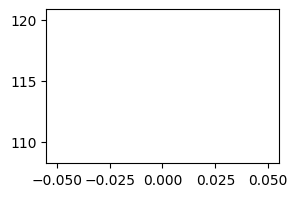

Epoch : 100/1000, Loss: 10.415608145345384, LR: 0.04
Epoch : 200/1000, Loss: 3.644192668310265, LR: 0.04


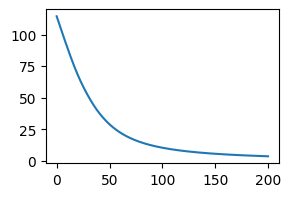

Epoch : 300/1000, Loss: 2.0834033232986515, LR: 0.04
Epoch : 400/1000, Loss: 1.4783108503937745, LR: 0.04


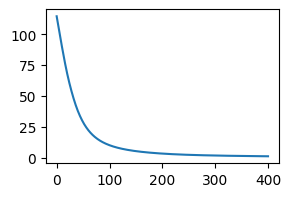

Epoch : 500/1000, Loss: 1.1574055432077939, LR: 0.02
Epoch : 600/1000, Loss: 1.0350546954953614, LR: 0.02


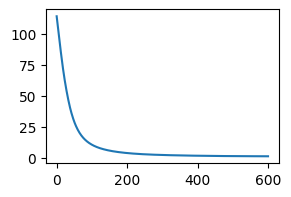

Epoch : 700/1000, Loss: 0.9577212709590258, LR: 0.02
Epoch : 800/1000, Loss: 0.9202721037483474, LR: 0.02


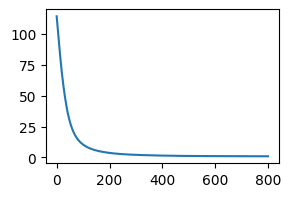

Epoch : 900/1000, Loss: 0.8961690811995858, LR: 0.02


In [42]:
import random
# arguments
device = 'cuda:0'
epoch = 1000 #2000
loss_f = torch.nn.L1Loss()
losses = [] 

# learning rate & decay step
lr = 0.04 # 0.03
decay_step = 500
gamma = 0.5

# optimized paramter (CRF & PEF)
initial_value = torch.ones(size =(cam_H*cam_W, 47))/2
initial_value = torch.logit(initial_value)
_opt_param =  torch.tensor(initial_value, dtype= torch.float, requires_grad=True, device= device)

# optimizer and schedular
optimizer = torch.optim.Adam([_opt_param], lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=decay_step, gamma = gamma)

# shape : 3, 47
PEF_dev = torch.tensor(PEF, dtype = torch.float).to(device).T
CRF_dev = torch.tensor(CRF, dtype = torch.float).to(device)
DG_efficiency_first_dev = torch.tensor(DG_efficiency_image_first.reshape(cam_H*cam_W, -1), device= device) # H x W, wvls
DG_efficiency_zero_dev = torch.tensor(DG_efficiency_image_zero.reshape(cam_H*cam_W, -1), device=device)

# depth scalar
A =  4.5 * 1e+5 # 10 * 1e+5 for peak # 4 * 1e+5 for tree
depth_scalar = ((depth.astype(np.int32))**2) / A

depth_scalar_dev = torch.tensor(depth_scalar, dtype = torch.float).to(device).T
# depth_scalar_dev = torch.ones_like(torch.tensor(depth_scalar), dtype = torch.float).to(device).T
# unreached_mask_tensor = torch.tensor(mask_idx.T, device=device).reshape(cam_H, cam_W, 47, 1)

# white pattern into multi-spectral channels
white_patt = torch.ones(size = (cam_H * cam_W, 3), device=device) * 0.8
white_patt_hyp = white_patt @ PEF_dev
white_patt_hyp = white_patt_hyp.squeeze()

GT_I_RGB_FIRST_tensor = torch.tensor(GT_I_RGB_FIRST, device=device)
GT_I_RGB_ZERO_tensor = torch.tensor(GT_I_RGB_ZERO, device=device)

rand_idx = [random.randint(0, 21) for _ in range(5)]

weight_first = 0
weight_zero = 1
weight_unreach = 0
weight_spectral = 0 # 50
weight_spatial_alot = 0 # 3
weight_spatial_mid = 0 # 2
weight_spatial_small = 0 #1

loss_vis = []
A_first = CRF_dev.unsqueeze(dim = 0) * white_patt_hyp.unsqueeze(dim = -1) * DG_efficiency_first_dev.unsqueeze(dim = -1)
A_zero = CRF_dev.unsqueeze(dim = 0) * white_patt_hyp.unsqueeze(dim = -1) * DG_efficiency_zero_dev.unsqueeze(dim = -1)

for i in range(epoch):
    # initial loss
    loss = 0

    opt_param = torch.sigmoid(_opt_param)
    # opt_param.data = torch.clamp(opt_param.data, min=0)

    Simulated_I_RGB_first = opt_param.unsqueeze(dim = -1) * A_first / depth_scalar_dev.unsqueeze(dim = -1).unsqueeze(dim = -1) 
    Simulated_I_RGB_zero = torch.sum(opt_param.unsqueeze(dim = -1) * A_zero / depth_scalar_dev.unsqueeze(dim = -1).unsqueeze(dim = -1), axis=1) 
    
    image_loss_first = torch.abs((Simulated_I_RGB_first.reshape(cam_H, cam_W, len(new_wvls), 3)) - GT_I_RGB_FIRST_tensor) * unreached_mask_tensor / (cam_H*cam_W)
    loss += weight_first * image_loss_first.sum()

    unreached_loss = torch.abs((Simulated_I_RGB_zero.reshape(cam_H, cam_W, 1, 3)) - GT_I_RGB_ZERO_tensor) * (1 - unreached_mask_tensor) / (cam_H*cam_W)
    image_loss_zero = torch.abs((Simulated_I_RGB_zero.reshape(cam_H, cam_W, 1, 3)) - GT_I_RGB_ZERO_tensor) / (cam_H*cam_W)
    
    loss += (weight_zero * image_loss_zero.sum() + weight_unreach*unreached_loss.sum())
    loss +=  weight_unreach*unreached_loss.sum()
    
    hyp_dL2 = ((opt_param[:,:-1] - opt_param[:,1:])**2).sum()/(cam_H*cam_W)
    
    # spatial tv
    opt_param = opt_param.reshape(cam_H, cam_W, len(new_wvls))
    spatial_H_dL2_alot = ((opt_param[:1,:,:19] - opt_param[:-1,:,:19])**2).sum()
    spatial_W_dL2_alot = ((opt_param[:,:1,:19] - opt_param[:,:-1,:19])**2).sum() # 19
    spatial_dL2_alot = (spatial_H_dL2_alot+spatial_W_dL2_alot)/(cam_H*cam_W*len(new_wvls[:19]))
    
    # midium spatial tv
    spatial_H_dL2_mid = ((opt_param[:1,:,19:27] - opt_param[:-1,:,19:27])**2).sum()
    spatial_W_dL2_mid = ((opt_param[:,:1,19:27] - opt_param[:,:-1,19:27])**2).sum()
    spatial_dL2_mid = (spatial_H_dL2_mid+spatial_W_dL2_mid)/(cam_H*cam_W*len(new_wvls[19:26]))

    # small spatial tv
    spatial_H_dL2_small = ((opt_param[:1,:,27:] - opt_param[:-1,:,27:])**2).sum()
    spatial_W_dL2_small = ((opt_param[:,:1,27:] - opt_param[:,:-1,27:])**2).sum()
    spatial_dL2_small = (spatial_H_dL2_small+spatial_W_dL2_small)/(cam_H*cam_W*len(new_wvls[26:]))

    loss += weight_spectral*(hyp_dL2) + weight_spatial_alot*(spatial_dL2_alot) + weight_spatial_mid *spatial_dL2_mid + weight_spatial_small*spatial_dL2_small

    loss = loss.sum()
    loss_vis.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    scheduler.step()
        
    if i % 100 == 0:
        print(f"Epoch : {i}/{epoch}, Loss: {loss.item()}, LR: {optimizer.param_groups[0]['lr']}")
        
        if i % 200 == 0:
            plt.figure(figsize=(3,2))
            plt.plot(loss_vis) #, plt.title(f"Epoch : {i}/{epoch}, Loss: {loss.item()}, LR: {optimizer.param_groups[0]['lr']}")
            plt.show()

In [ ]:
end optimization

SyntaxError: invalid syntax (315004624.py, line 1)

### Depth scalar

In [ ]:
depth_reshape = depth.reshape(580, 890)

(<matplotlib.image.AxesImage at 0x1c38804a808>,
 <matplotlib.colorbar.Colorbar at 0x1c398113148>)

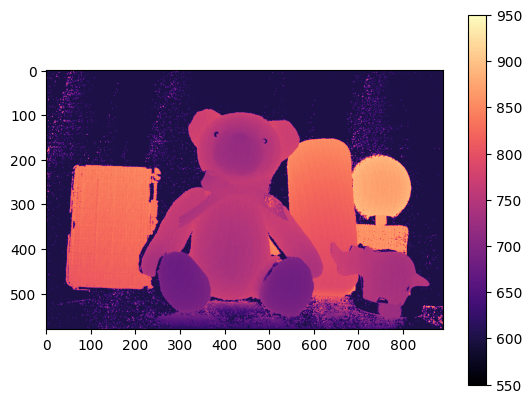

In [ ]:
plt.imshow(depth_reshape, cmap = 'magma', vmin = 550, vmax = 950), plt.colorbar()

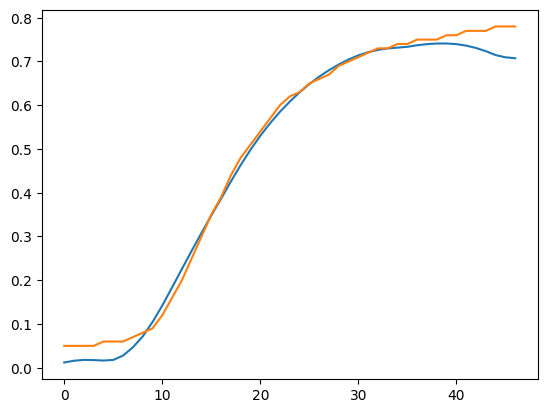

In [ ]:
i = 15
A = 7 * 1e+5
depth_scalar = ((depth.reshape(580, 890).astype(np.int32))**2) / A
opt_param_detach = opt_param.reshape(cam_H, cam_W, 47).detach().cpu().numpy()

plt.plot(opt_param_detach[all_patches_center_pts[i,1],all_patches_center_pts[i,0]]/depth_scalar.reshape(cam_H, cam_W)[all_patches_center_pts[i,1],all_patches_center_pts[i,0]], label='estimated')
plt.plot(ref_CC[:,i], label='GT')

### visualization

In [ ]:
np.save('opt_param.npy', opt_param.detach().cpu().numpy().reshape(580*890, 47))

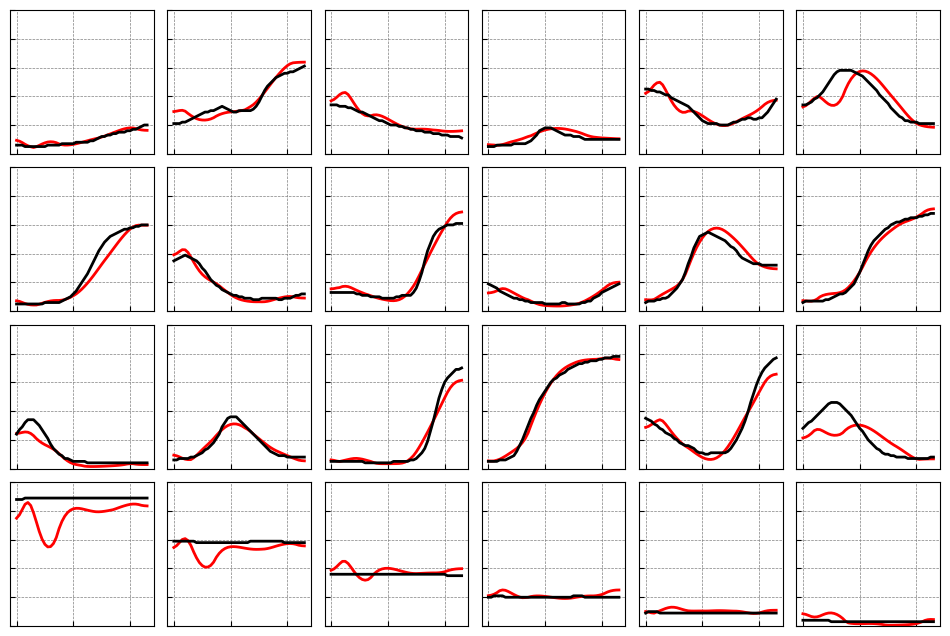

In [ ]:
# Figure visualization 4x6 격자 배열의 subplot을 생성
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(12, 8), gridspec_kw={'wspace':0.095, 'hspace':0.095})
new_reflectance = opt_param.reshape(cam_H, cam_W, 47).detach().cpu().numpy()
x_axis = np.arange(430, 661, 50)

for i in range(24):
    ax = axes[i//6, i%6]
    ax.set_ylim([0,1])
    ax.plot(new_reflectance[all_patches_center_pts[i,1],all_patches_center_pts[i,0]], c = 'red', linewidth = 2)
    ax.plot(ref_CC[:,i], c= 'black', linewidth = 2)
    
    # Erasing y-axis and x-axis labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Setting ticks direction to inward
    ax.tick_params(axis='x', direction='in')
    ax.tick_params(axis='y', direction='in')
    
    # Adding dotted light gray grid lines
    ax.grid(color='gray', linestyle='--', linewidth=0.5)
plt.savefig('./color_check.svg')
# # Reducing space between the subplots
# plt.subplots_adjust(wspace=0.5, hspace=0.5)

# plt.tight_layout()
# plt.show()

# fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(12, 8))
# new_reflectance = opt_param.reshape(cam_H, cam_W, 47).detach().cpu().numpy()
# x_axis = np.arange(430, 661, 50)

# for i in range(24):
#     axes[i//6, i%6].set_ylim([0,1])
#         # data = np.random.random((10,))  # 예시로 10개의 랜덤 데이터 생성
#     axes[i//6, i%6].plot(new_reflectance[all_patches_center_pts[i,1],all_patches_center_pts[i,0]] , label='estimated')
#     axes[i//6, i%6].plot(ref_CC[:,i], label='GT')
#     axes[i//6, i%6].set_title(f'Plot {i + 1}')  # 그래프 제목 설정

# plt.grid(color = 'lightgray')
    
# # subplot 간의 간격 조정
# plt.tight_layout()
# plt.grid()
# # 그래프 표시
# plt.show()

### Point Visualization

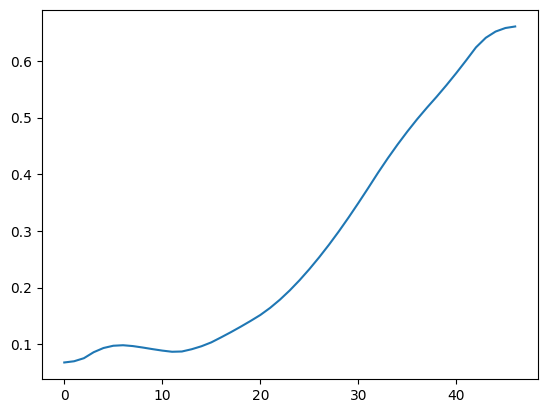

In [ ]:
plt.plot(new_reflectance[351,657]) # [367, 381] # [443,806] [226,762]

### Peak plotting

In [ ]:
opt_param_detach = opt_param.detach().cpu().numpy().reshape(cam_H, cam_W, len(new_wvls))
# np.save('opt_param_zero.npy', opt_param_detach)

In [ ]:
# opt_param_detach = np.load('./opt_param_first.npy')
opt_param_zero = np.load('./opt_param_zero.npy')
band_pass_transmission = np.load('./dataset/band_pass_transmission.npy')
procam_ssfm_ref = np.load('./procam_ssfm_ref.npy').reshape(cam_H, cam_W, len(new_wvls))

In [ ]:
# peak_wvl = np.array([570, 560, 550])
peak_wvl = np.array([470, 460, 450, 570, 560, 550, 620, 610, 600])
x_axis = np.arange(430, 661, 50)
c = ['red', 'green', 'blue']

In [ ]:
# 20231114 
all_patches_center_pts = np.array([[570,208], [570,305],[580,414],
                                   [647,206], [655,310],[658,416],
                                   [723,201], [720,316],[741,418]]) # 728 210

# # 20231114 
# all_patches_center_pts = np.array([[570,208], [570,305],[580,414],
#                                    [647,206], [655,310],[658,416],
#                                    [728,210], [730,310],[736,418]])

In [ ]:
i = 2

data = opt_param_detach[all_patches_center_pts[i,1],all_patches_center_pts[i,0]]
# data = opt_param_zero[all_patches_center_pts[i,1],all_patches_center_pts[i,0]]
# data =  band_pass_transmission[i]
# data = procam_ssfm_ref[all_patches_center_pts[i,1],all_patches_center_pts[i,0]]

# Step 1: Find the max value and its index
max_value = np.max(data)
max_index = np.argmax(data)

# Step 2: Half max value
half_max = max_value / 2

if max_index == 0:
    fwhm_start = np.argmin(np.abs(data[0] - half_max))
    fwhm_end = np.argmin(np.abs(data[max_index:] - half_max)) + max_index
else:
    # Step 3 and 4: Find indices where value is half max and calculate FWHM
    fwhm_start = np.argmin(np.abs(data[:max_index] - half_max))
    fwhm_end = np.argmin(np.abs(data[max_index:] - half_max)) + max_index

# Calculate the FWHM
fwhm = (fwhm_end - fwhm_start) *5

print(f"FWHM: {fwhm}")

FWHM: 20


In [ ]:
# all_patches_center_pts = np.array([[551,149], [584,254],[550,357]])

620nm tensor(615.0001)


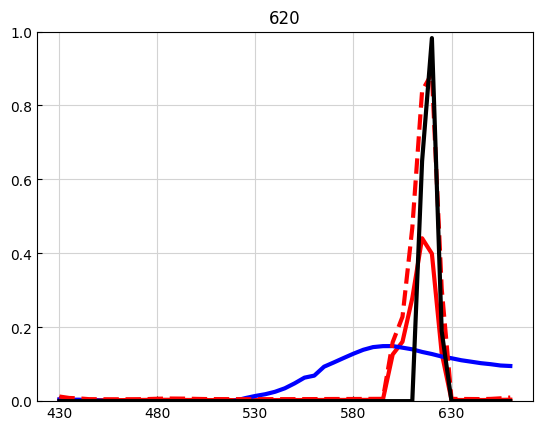

In [ ]:
fig, ax = plt.subplots()
# for i in range(len(all_patches_center_pts)):
for i in range(6,7):
    plt.ylim([0,1])
    argmax_idx = np.argmax(opt_param_detach[all_patches_center_pts[i,1],all_patches_center_pts[i,0]])
    
    if i < 6:
        ax.plot(new_wvls*1e9, opt_param_detach[all_patches_center_pts[i,1],all_patches_center_pts[i,0]], label = peak_wvl[i], linewidth = 3, c = 'red'), plt.title(peak_wvl[i])
        ax.plot(new_wvls*1e9, procam_ssfm_ref[all_patches_center_pts[i,1],all_patches_center_pts[i,0]]*0.8, c = 'blue', linewidth = 3)
        ax.plot(new_wvls*1e9, opt_param_zero[all_patches_center_pts[i,1],all_patches_center_pts[i,0]]*0.8, label = peak_wvl[i], linewidth = 3, c = 'red', linestyle = '--' )

    else:
        if i == 8:
            opt_param_detach[all_patches_center_pts[i,1],all_patches_center_pts[i,0],:30] = 0.005
        ax.plot(new_wvls*1e9, opt_param_detach[all_patches_center_pts[i,1],all_patches_center_pts[i,0]], label = peak_wvl[i], linewidth = 3, c = 'red'), plt.title(peak_wvl[i])
        ax.plot(new_wvls*1e9, procam_ssfm_ref[all_patches_center_pts[i,1],all_patches_center_pts[i,0]] *2, c = 'blue', linewidth = 3)
        ax.plot(new_wvls*1e9, opt_param_zero[all_patches_center_pts[i,1],all_patches_center_pts[i,0]]*2, label = peak_wvl[i], linewidth = 3, c = 'red', linestyle = '--' )

    # ax.plot(new_wvls*1e9, opt_param_zero[all_patches_center_pts[i,1],all_patches_center_pts[i,0]], label = peak_wvl[i], linewidth = 3, c = 'red', linestyle = '--' )
    ax.plot(new_wvls*1e9, band_pass_transmission[i] / 100, c = 'black', linewidth = 3)
    # ax.plot(new_wvls*1e9, procam_ssfm_ref[all_patches_center_pts[i,1],all_patches_center_pts[i,0]]*0.8, c = 'blue', linewidth = 3)
        
    ax.set_xticks(x_axis)
    ax.tick_params(direction='in')
    plt.grid(color = 'lightgray')
    # plt.legend()
    print('%dnm'%peak_wvl[i], new_wvls[argmax_idx]*1e9)

### Hyperspectral reflectance image show

In [ ]:
opt_param_filtered = np.array([ndimage.median_filter(opt_param.detach().cpu().numpy()[:,:,i], size = 5) for i in range(len(new_wvls))])

In [ ]:
wvl_title = (new_wvls*1e9).to(torch.int16)

for i in range(36,40):
    if i < 19:
        plt.imshow(opt_param_filtered[i]*2.1, vmin = 0, vmax=1, cmap = 'gray'), plt.title('%dnm'%wvl_title[i]), plt.colorbar()
    elif i < 26:
        plt.imshow(opt_param_filtered[i]*1.0, vmin = 0, vmax=1, cmap = 'gray'), plt.title('%dnm'%wvl_title[i]), plt.colorbar()
    else:
        plt.imshow(opt_param_filtered[i]*2, vmin = 0, vmax=1, cmap = 'gray'), plt.title('%dnm'%wvl_title[i]), plt.colorbar()

    plt.show()

In [44]:
procam = np.load("./procam_ssfm_ref.npy")

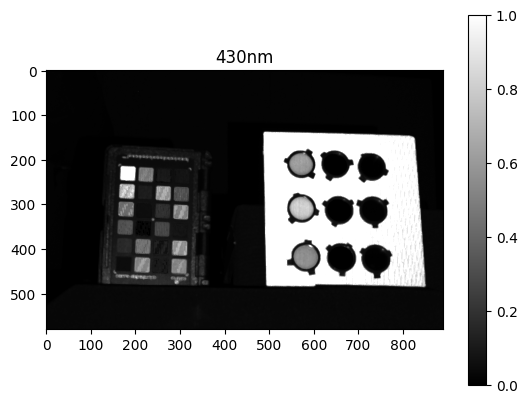

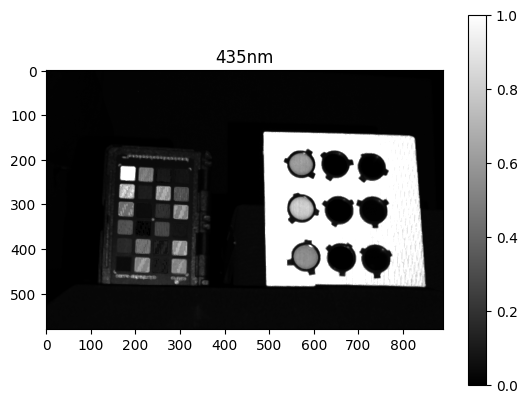

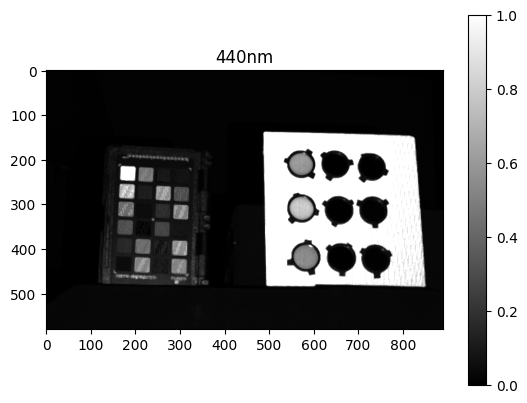

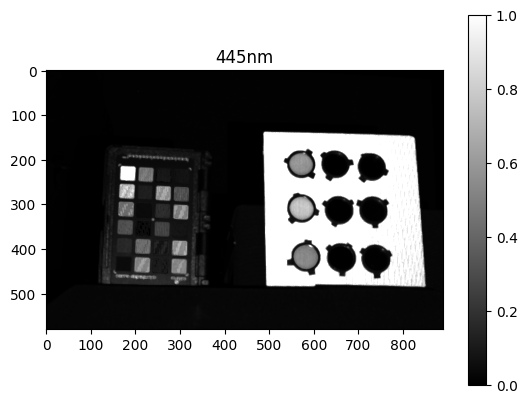

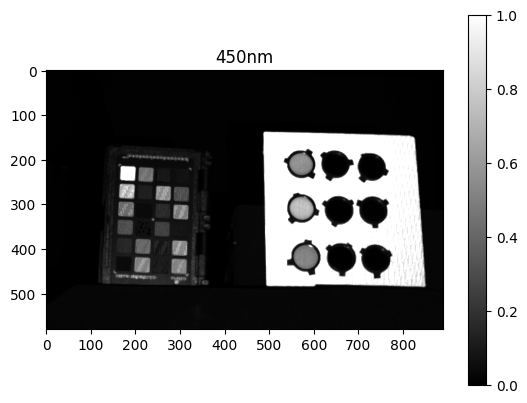

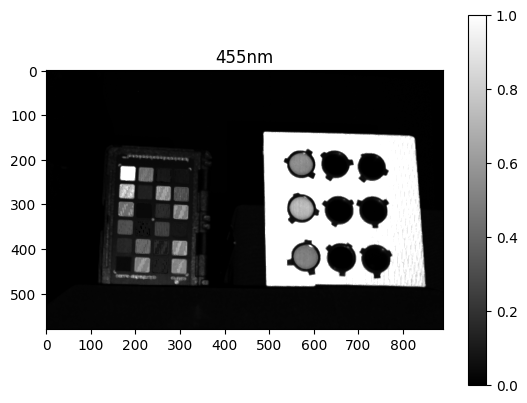

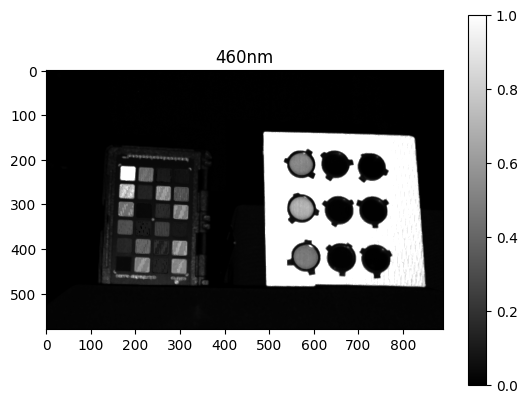

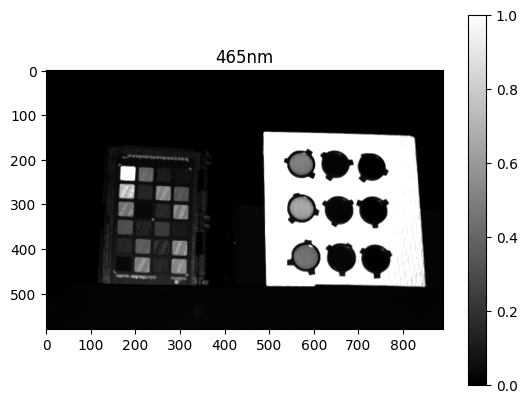

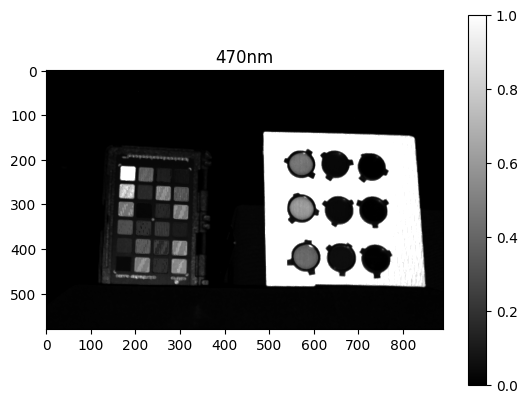

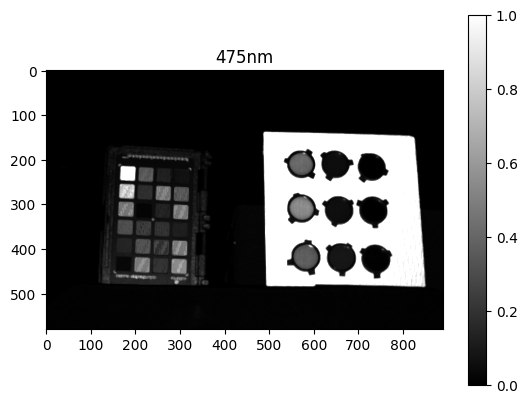

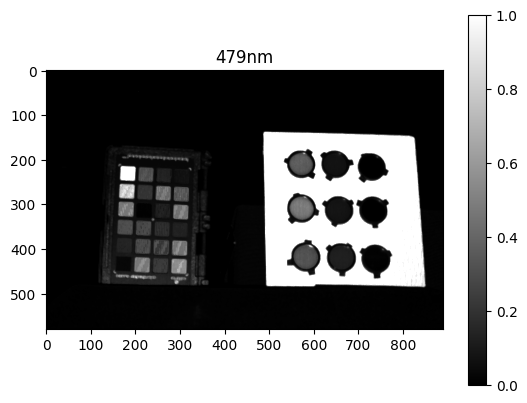

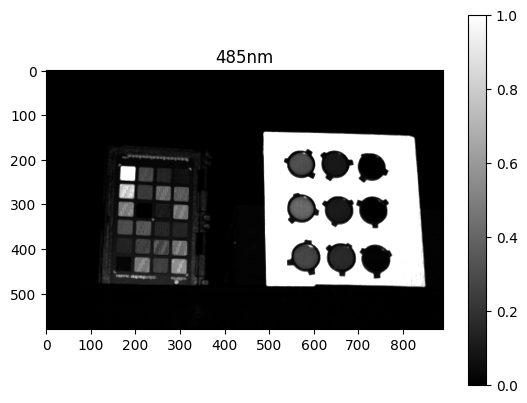

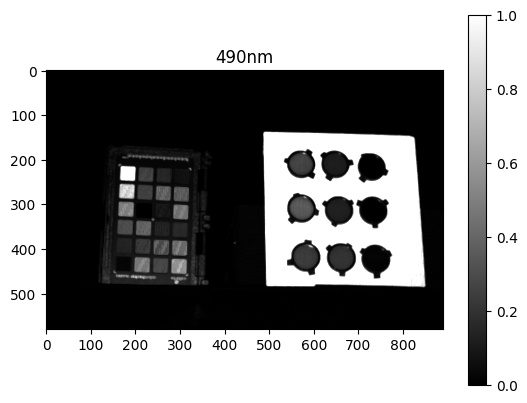

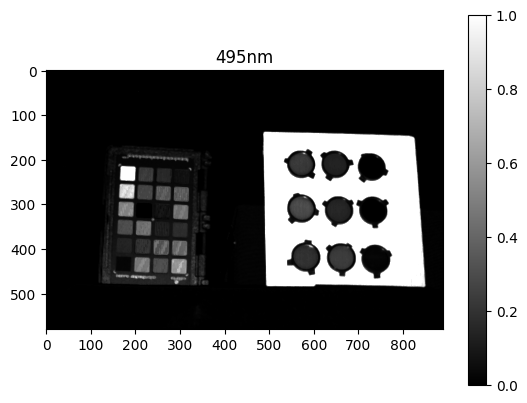

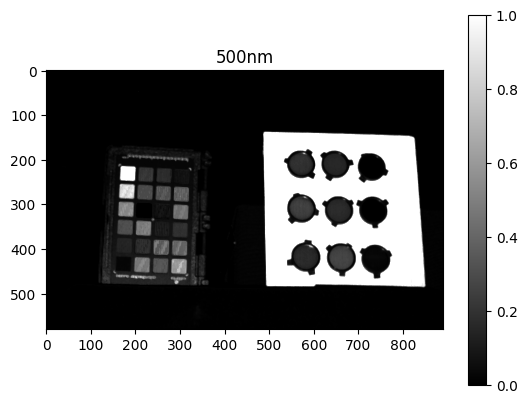

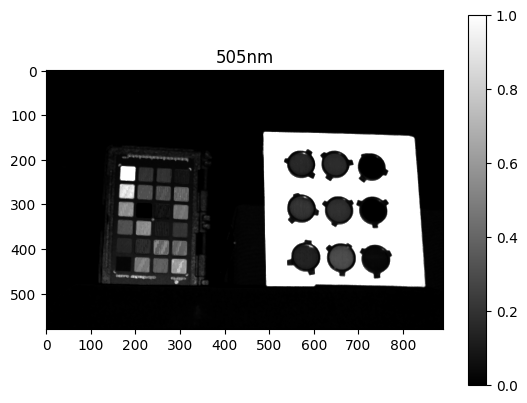

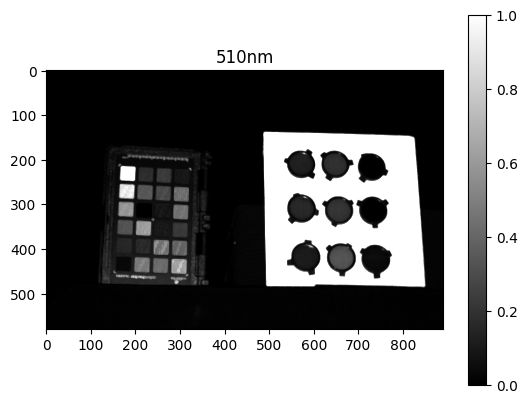

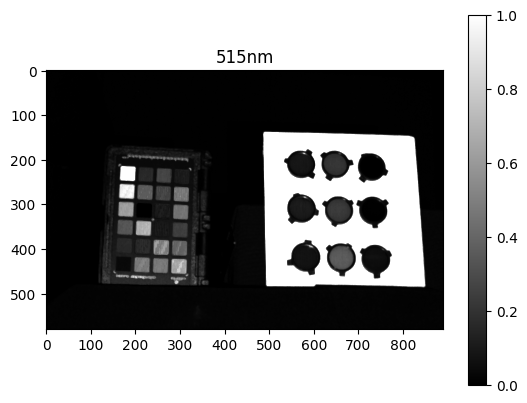

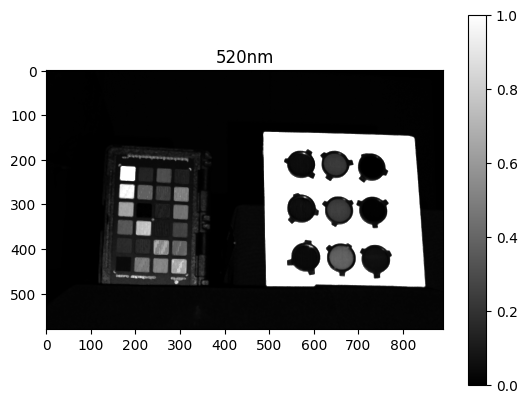

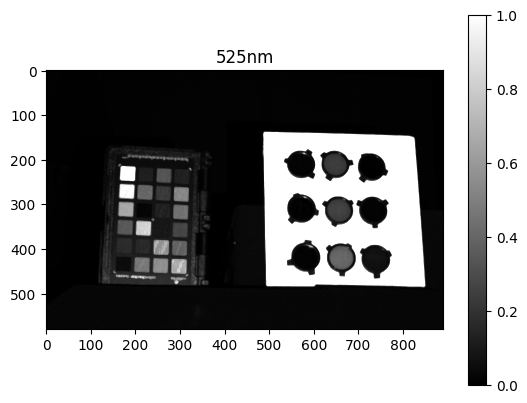

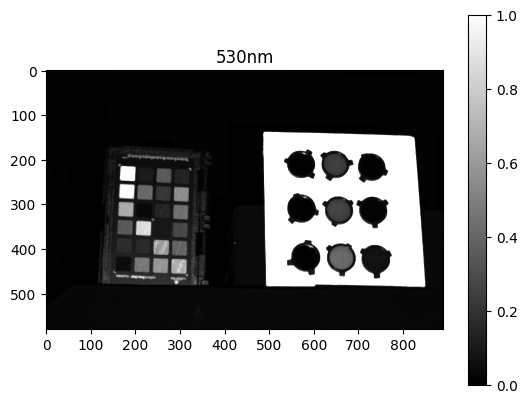

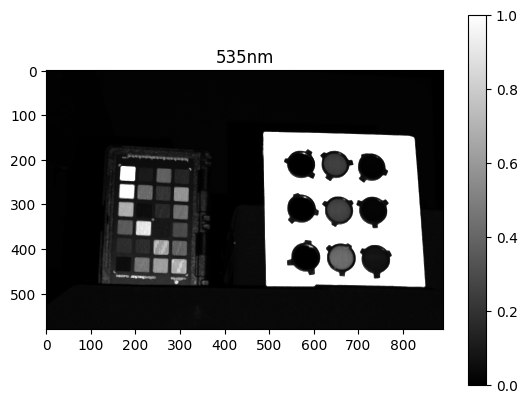

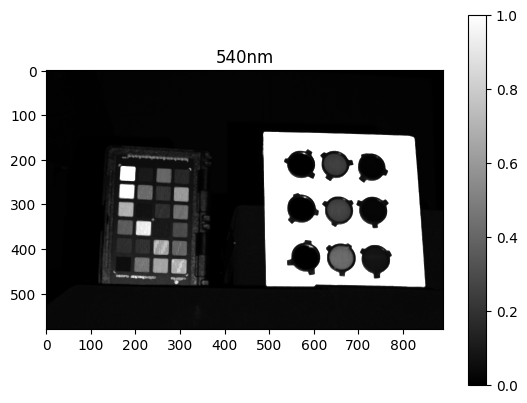

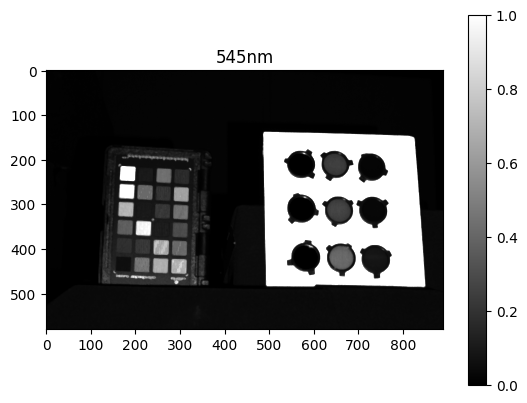

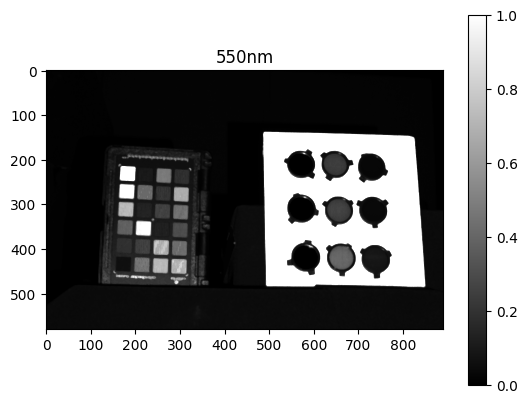

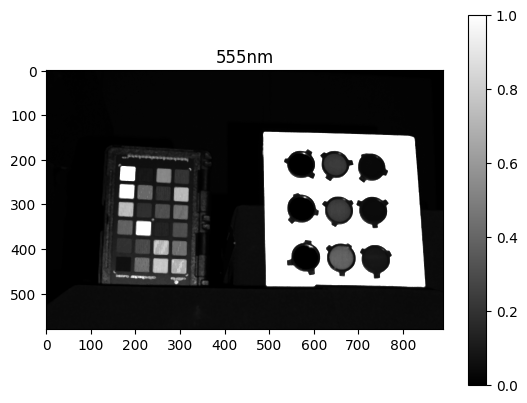

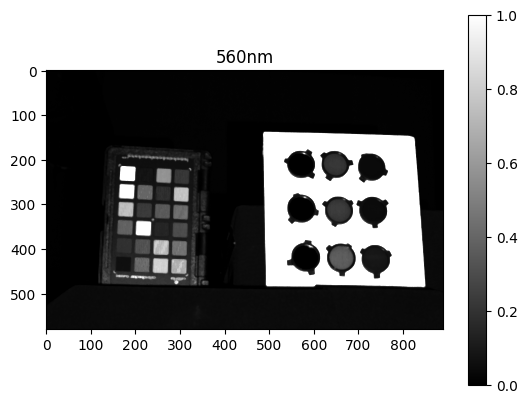

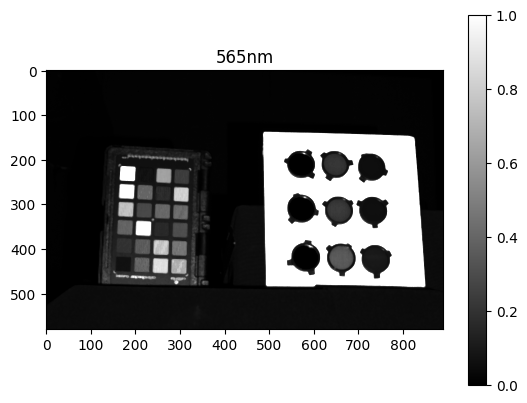

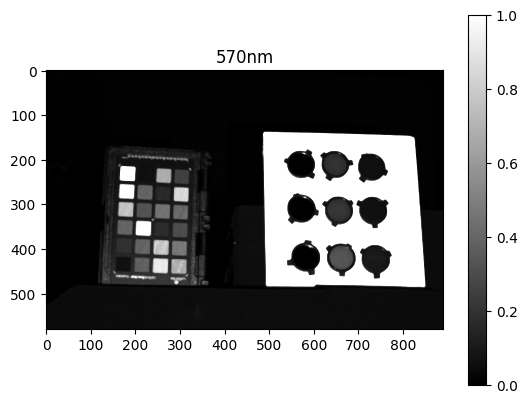

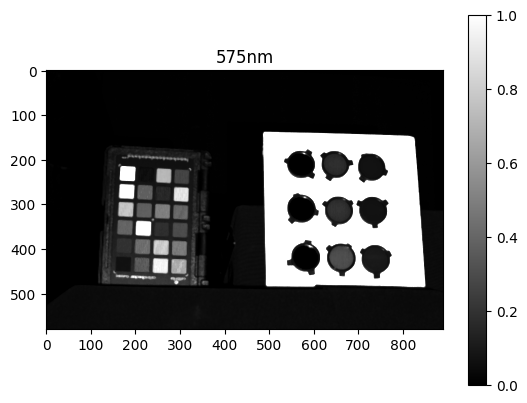

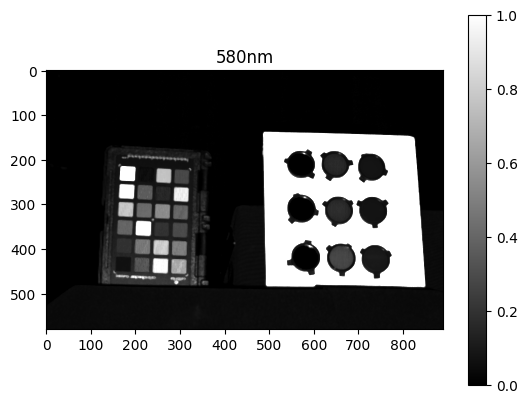

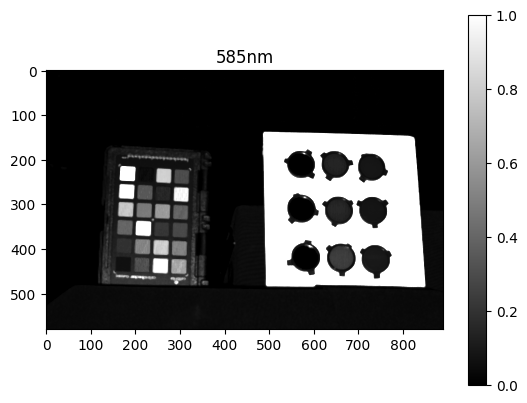

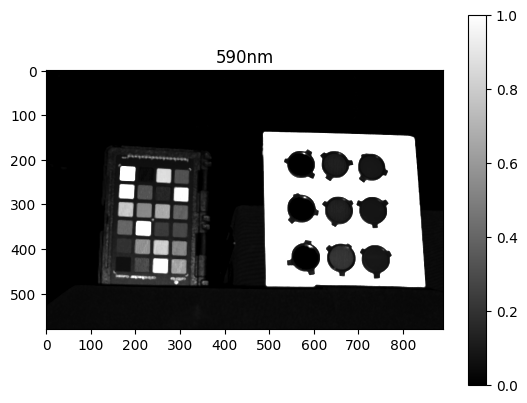

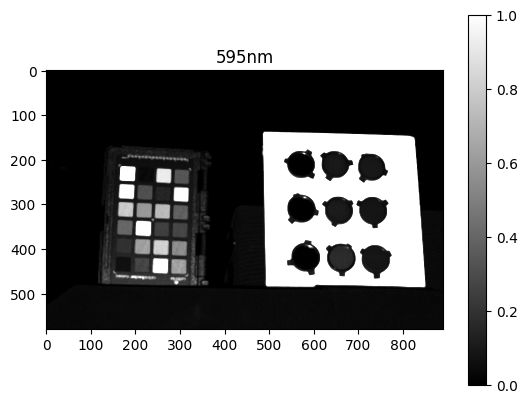

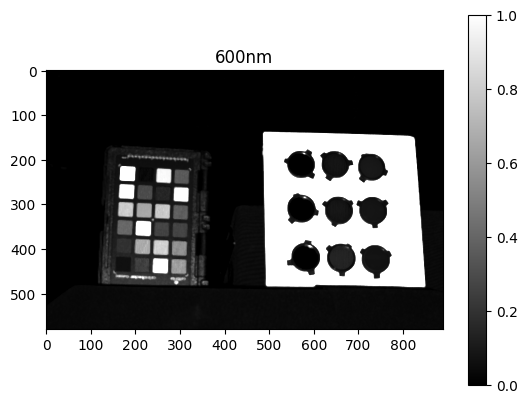

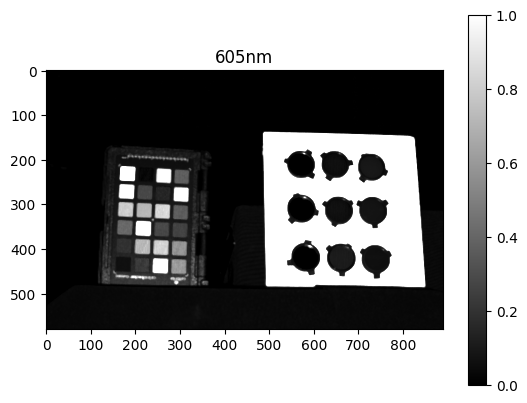

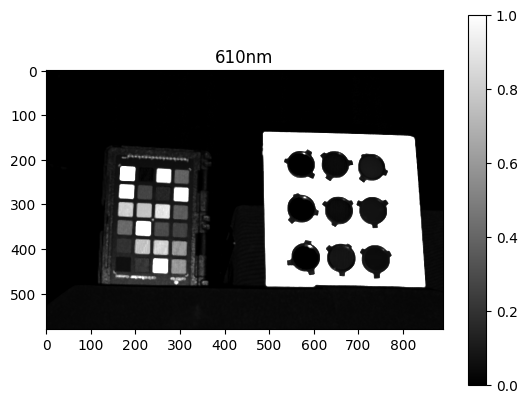

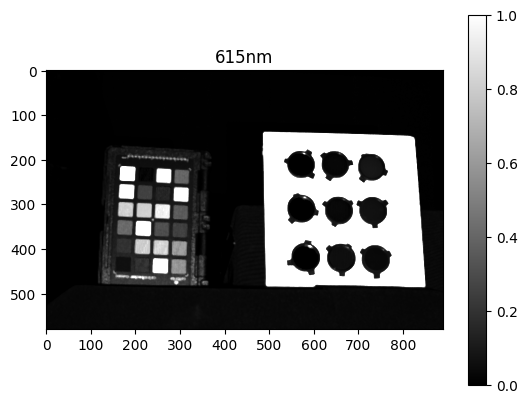

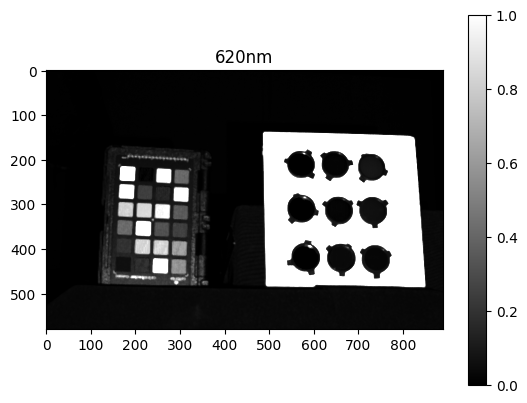

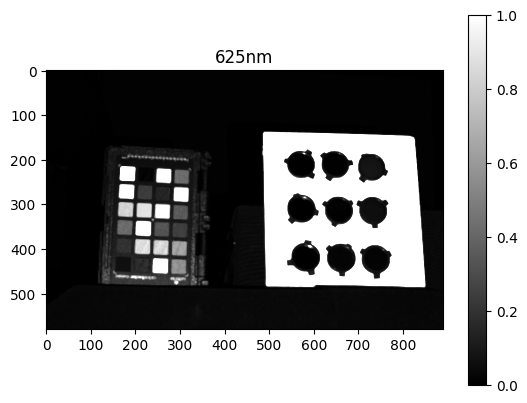

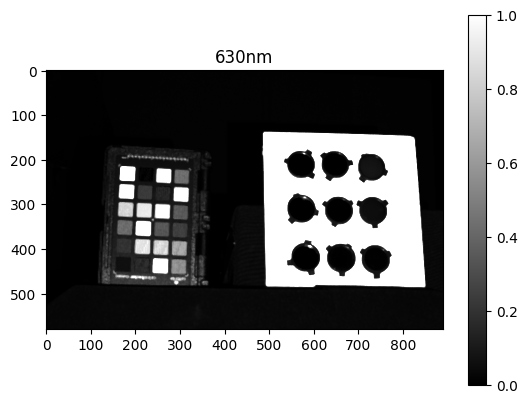

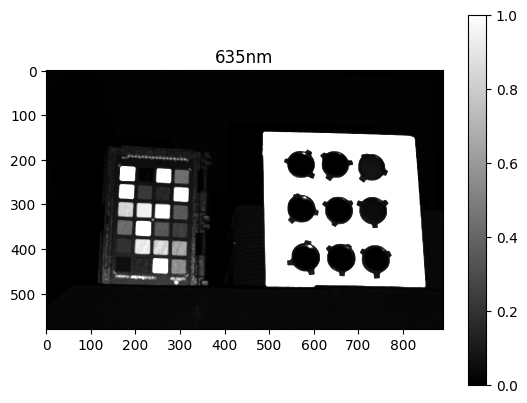

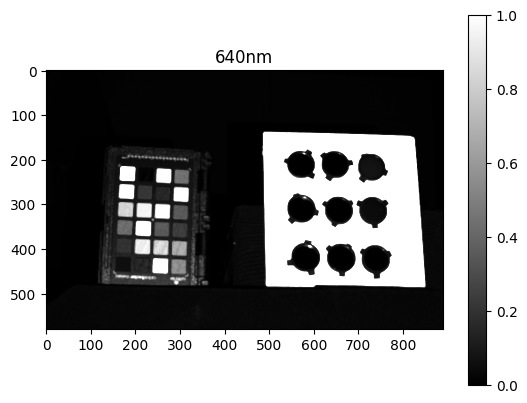

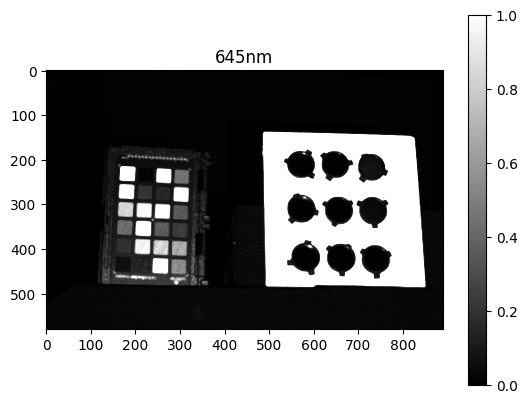

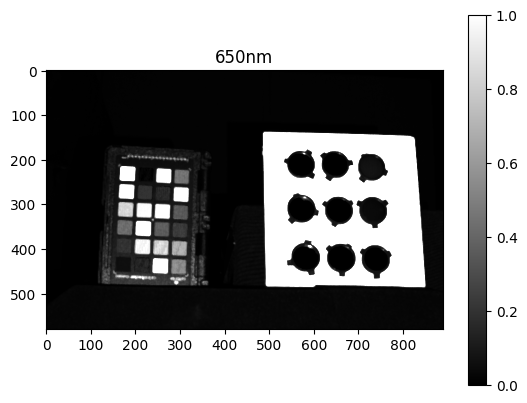

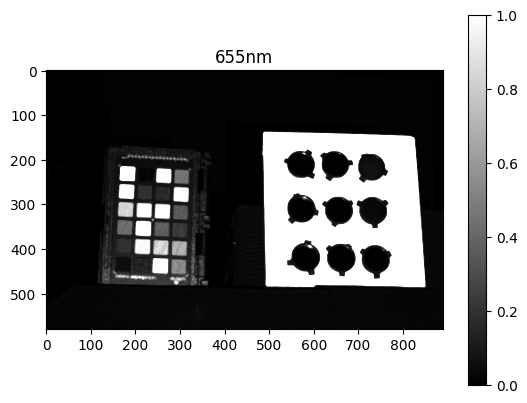

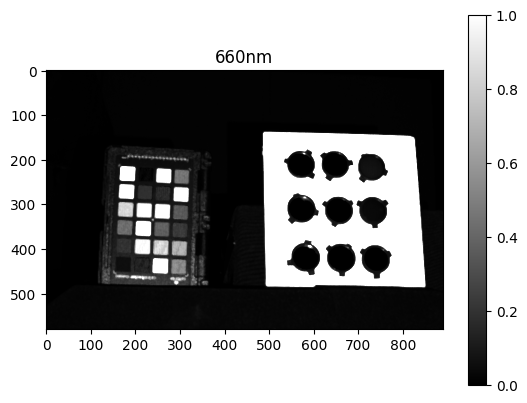

In [48]:
for i in range(47):
    
    plt.imshow(procam.reshape(580,890,47)[:,:,i]*1.2, vmin = 0, vmax=1, cmap = 'gray'), plt.title('%dnm'%wvl_title[i]), plt.colorbar()
    # plt.savefig('./%dnm.svg'%wvl_title[i])
    plt.show()

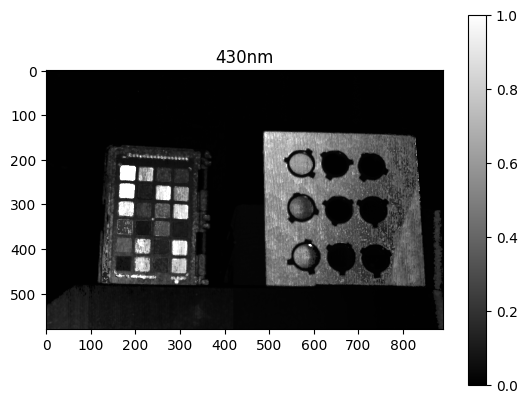

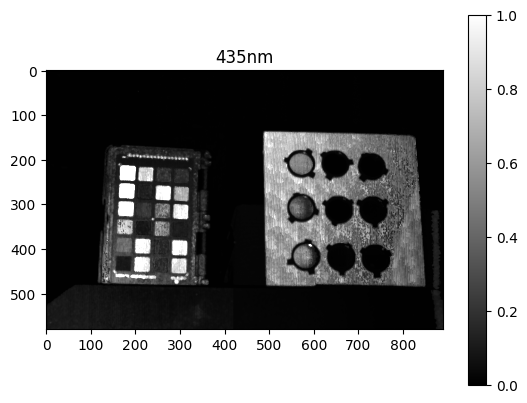

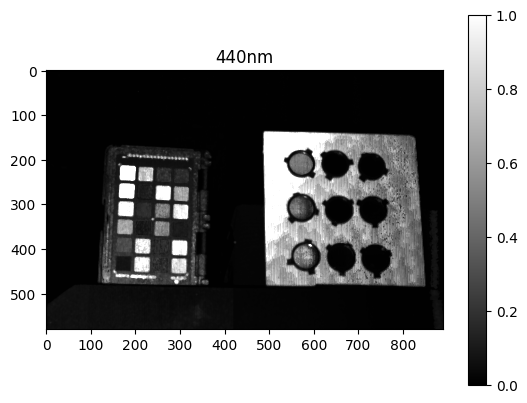

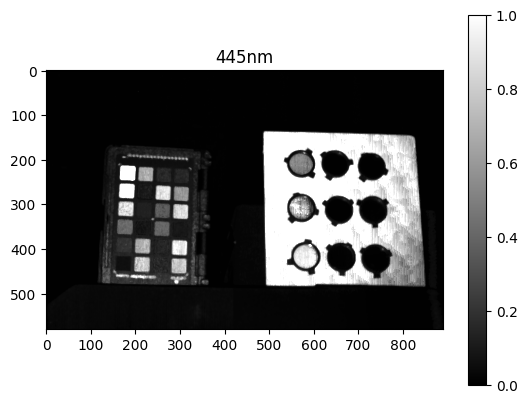

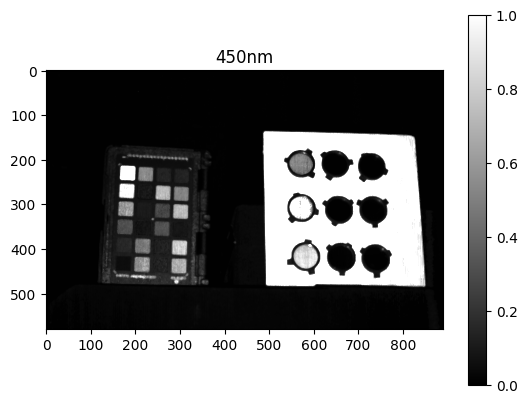

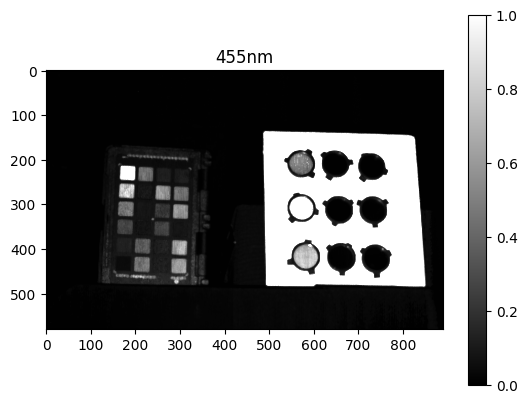

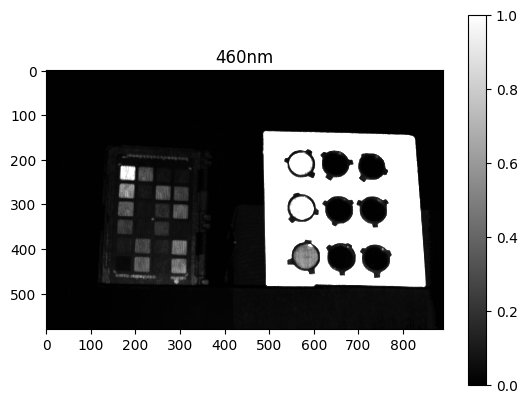

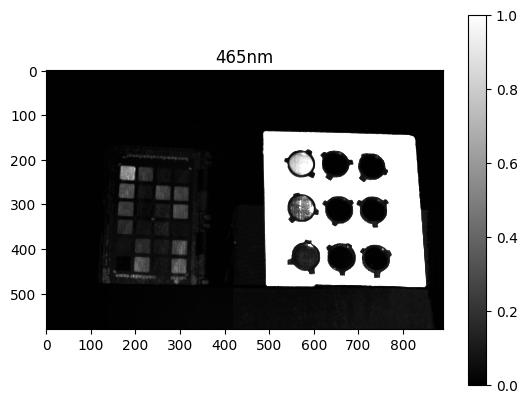

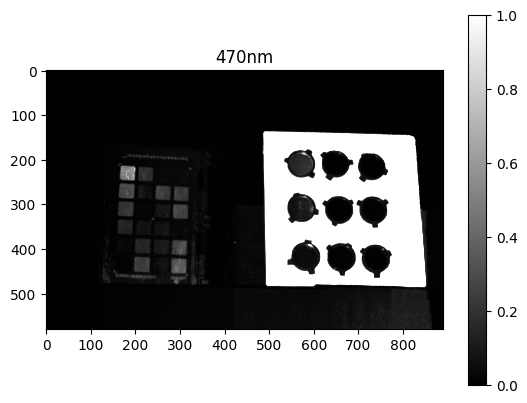

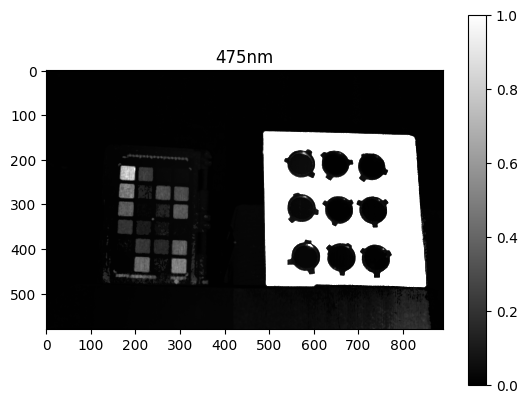

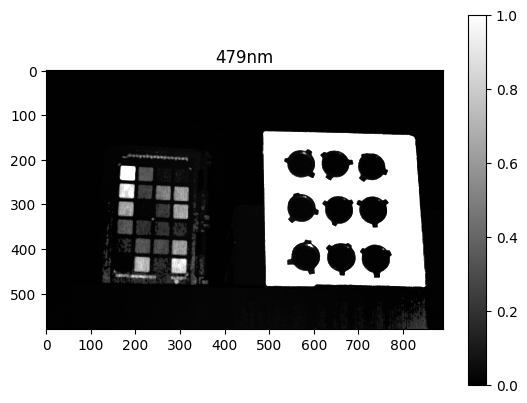

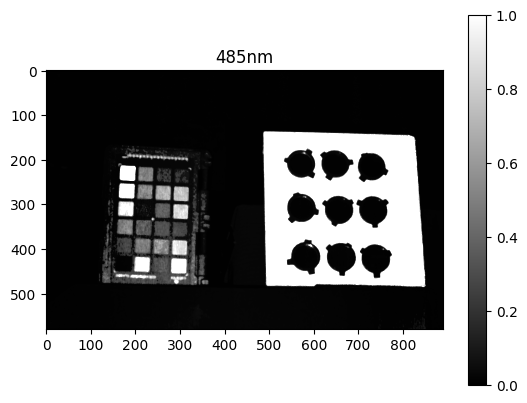

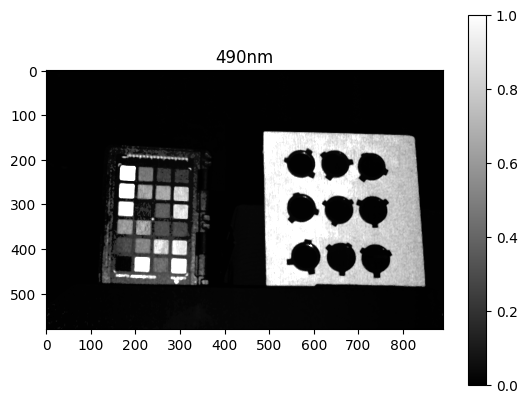

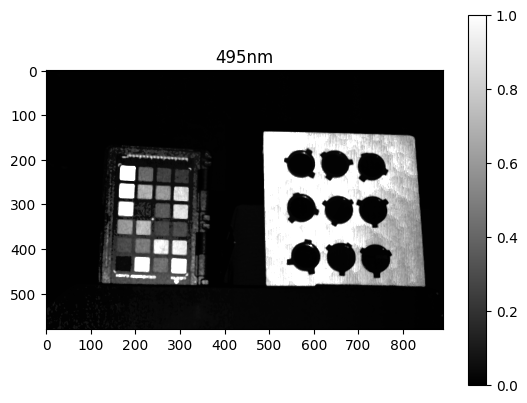

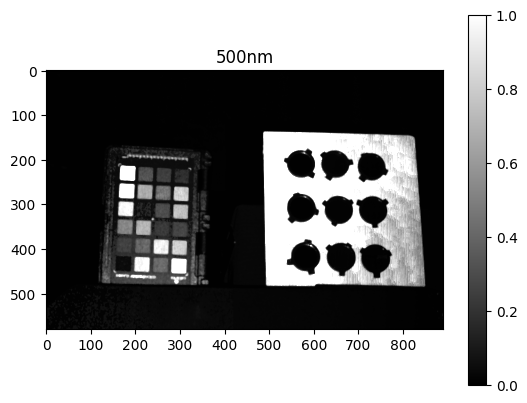

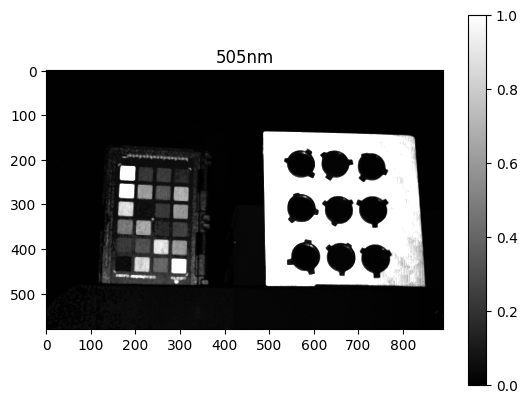

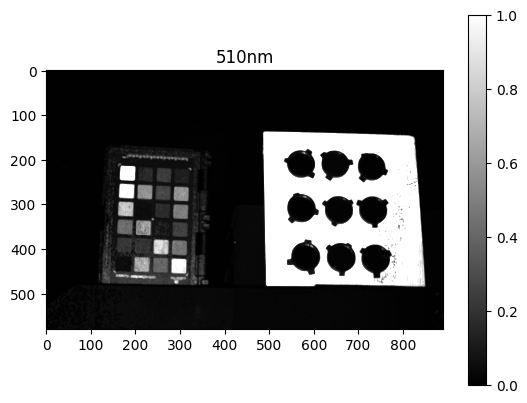

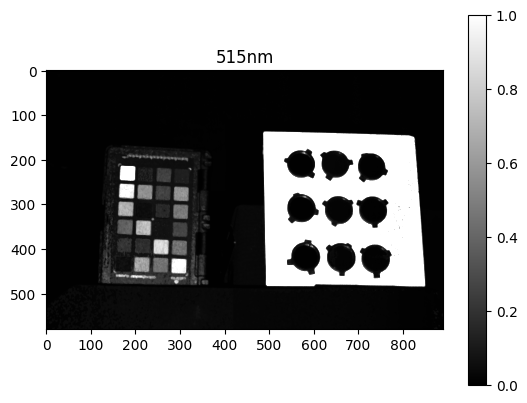

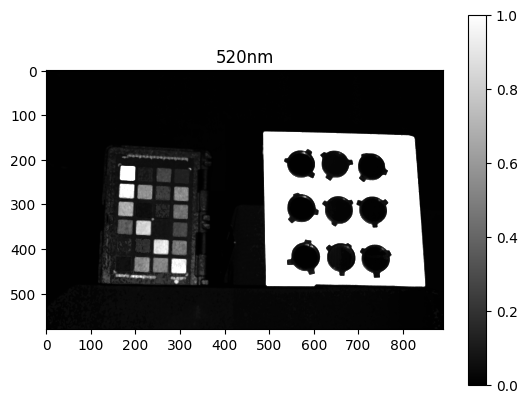

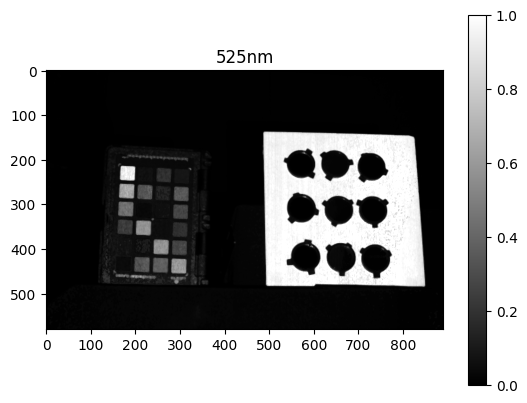

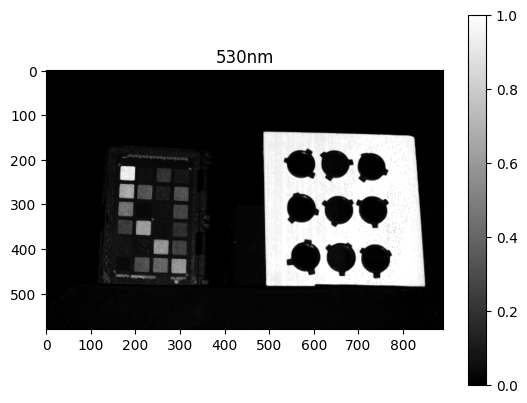

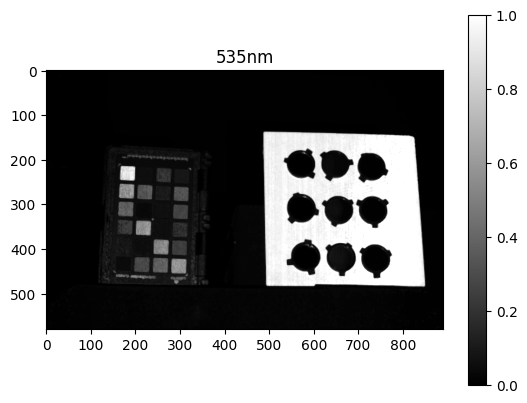

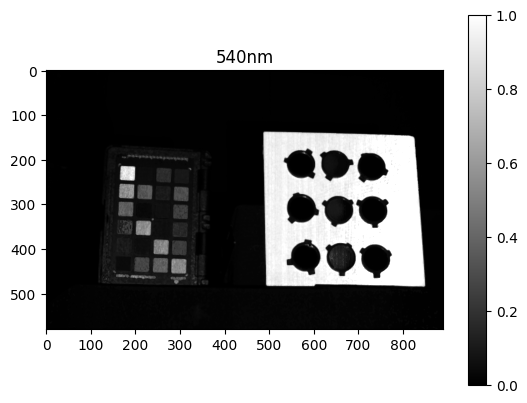

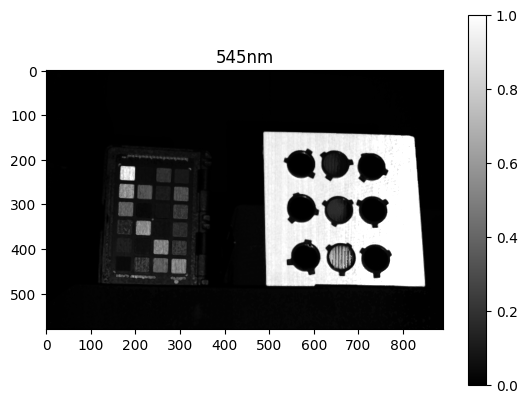

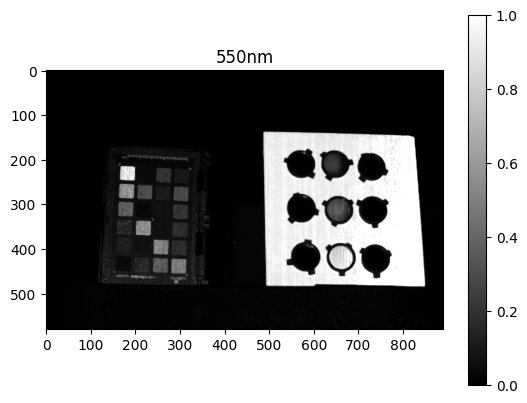

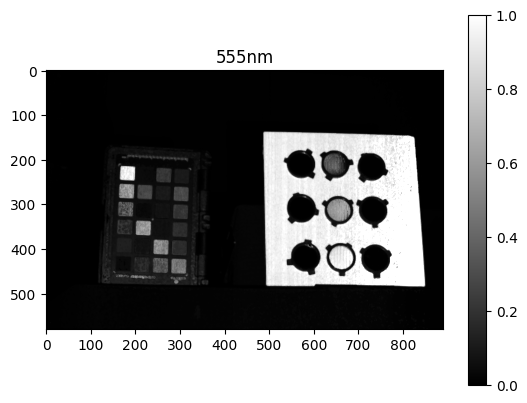

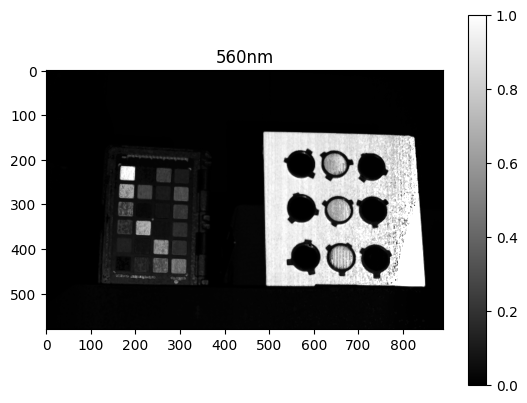

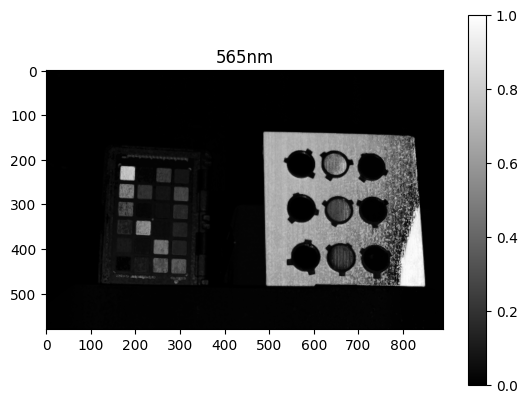

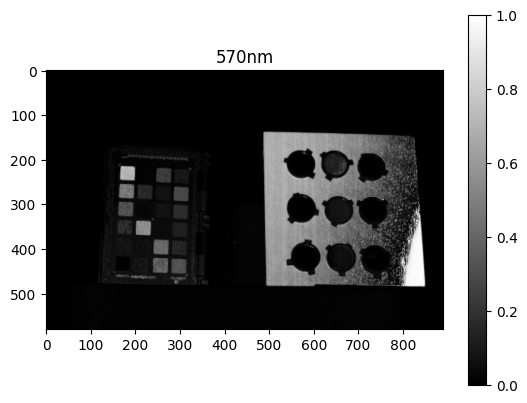

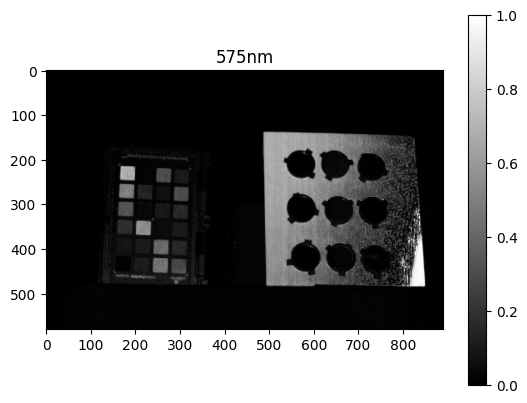

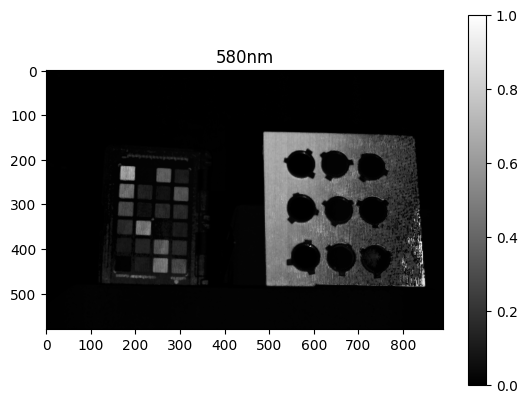

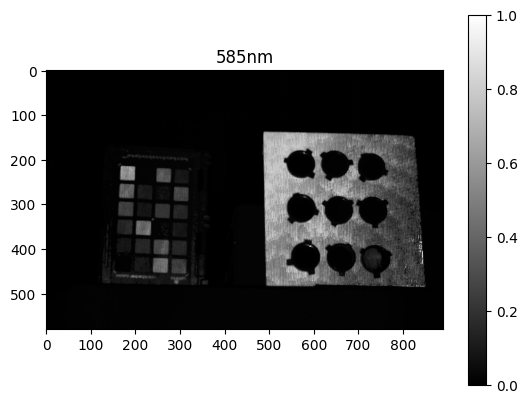

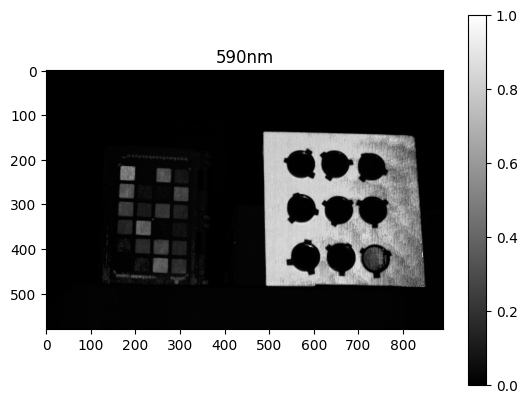

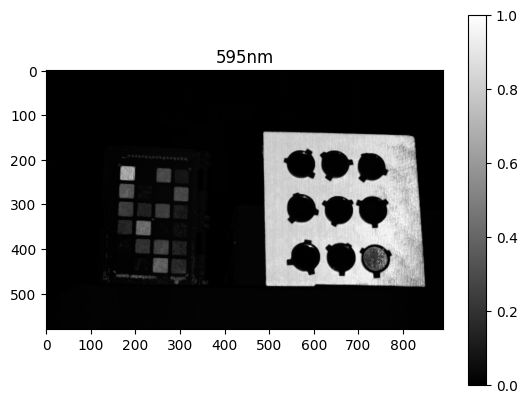

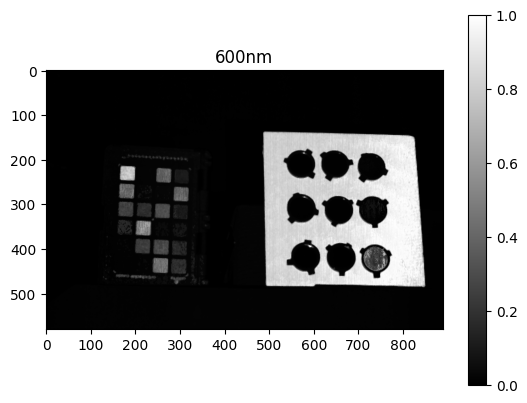

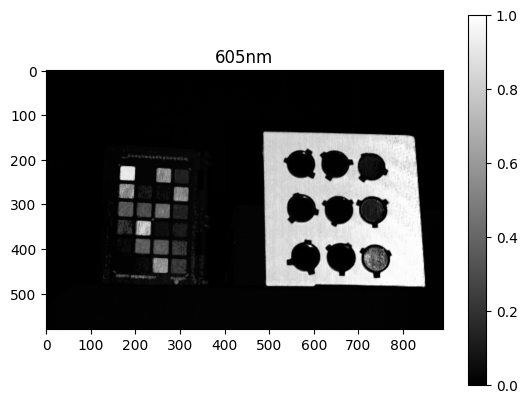

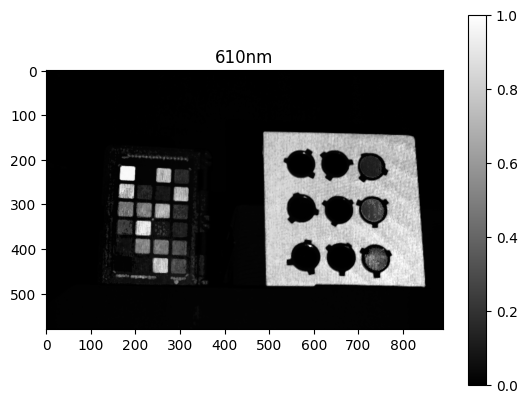

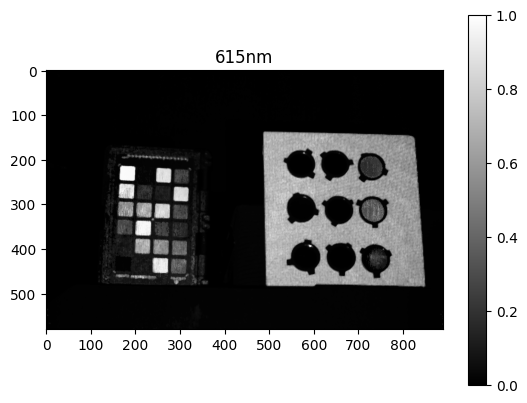

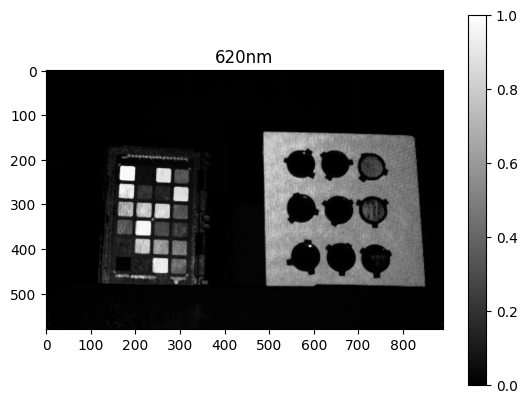

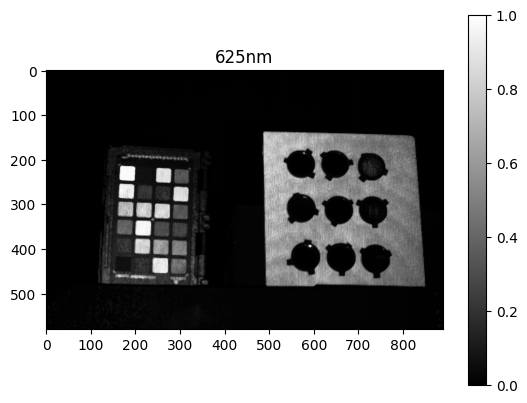

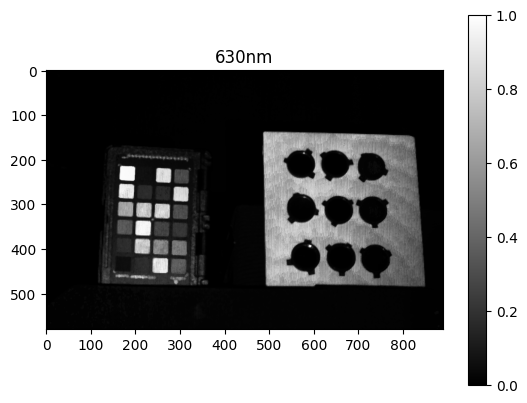

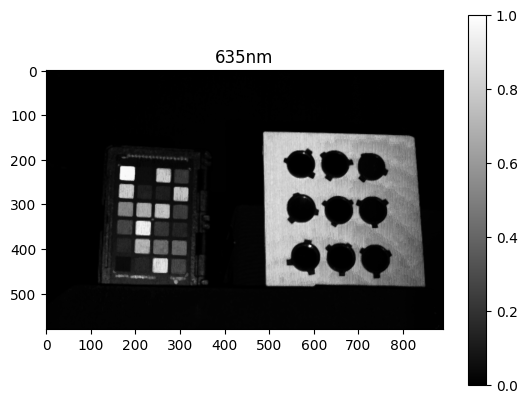

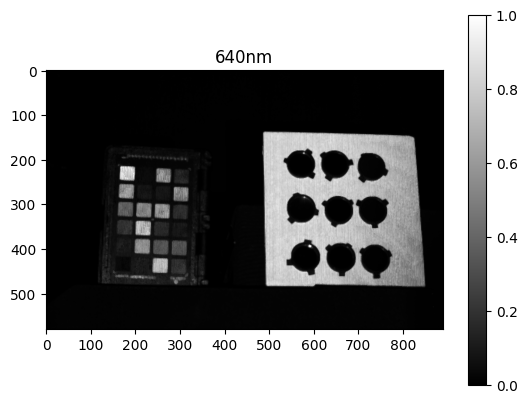

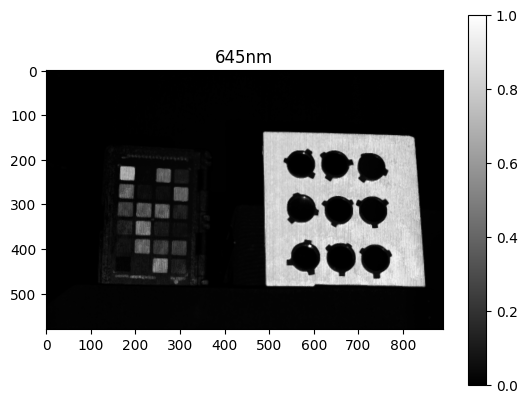

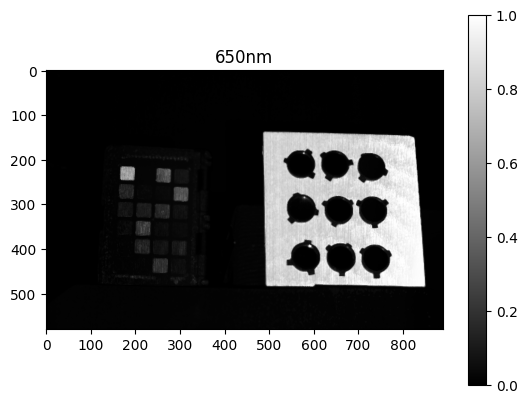

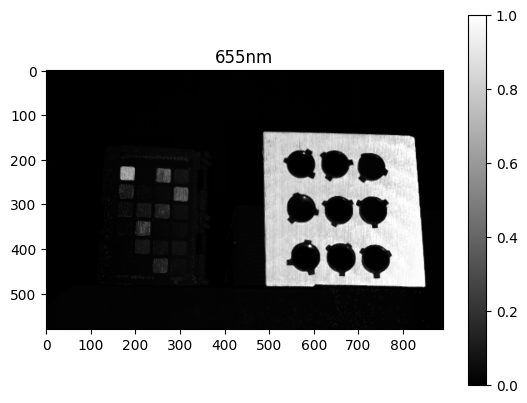

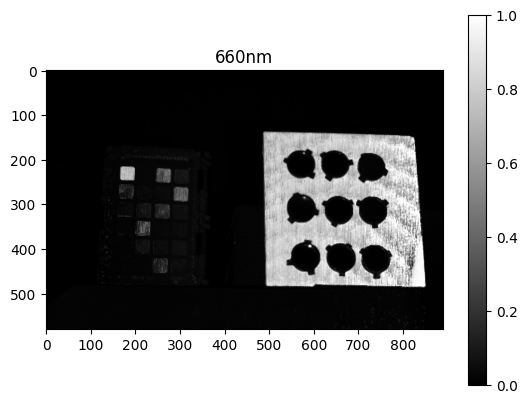

In [43]:
wvl_title = (new_wvls*1e9).to(torch.int16)

for i in range(47):
    if i < 19:
        plt.imshow(opt_param.detach().cpu().numpy()[:,:,i]*2.1, vmin = 0, vmax=1, cmap = 'gray'), plt.title('%dnm'%wvl_title[i]), plt.colorbar()
    elif i < 27:
        plt.imshow(opt_param.detach().cpu().numpy()[:,:,i]*1.3, vmin = 0, vmax=1, cmap = 'gray'), plt.title('%dnm'%wvl_title[i]), plt.colorbar()
    else:
        plt.imshow(opt_param.detach().cpu().numpy()[:,:,i], vmin = 0, vmax=1, cmap = 'gray'), plt.title('%dnm'%wvl_title[i]), plt.colorbar()

    plt.show()

# for i in range(47):
    
#     plt.imshow(opt_param.detach().cpu().numpy()[:,:,i], vmin = 0, vmax=1, cmap = 'gray'), plt.title('%dnm'%wvl_title[i]), plt.colorbar()
#     # plt.savefig('./%dnm.svg'%wvl_title[i])
#     plt.show()

In [ ]:
# idx = np.arange(0, 47, 2)
# wvl_title = (new_wvls*1e9).to(torch.int16)

# opt_param_detach = opt_param.detach().cpu().numpy()
# a = (opt_param_detach[..., np.newaxis])


# for i in range(47):
#     fig, ax = plt.subplots()
#     plt.imshow(a.reshape(cam_H, cam_W, -1)[:,:,i], vmin = 0, vmax=1, cmap = 'gray')#, plt.colorbar()
#     ax.axes.xaxis.set_visible(False)
#     ax.axes.yaxis.set_visible(False)
    
#     cv2.imwrite('%dnm.png'%(new_wvls[i]*1e9), a.reshape(cam_H, cam_W, -1)[:,:,i]*255.)
#     # plt.savefig('%dnm'%(new_wvls[i]*1e9))
#     plt.show()

In [ ]:
idx = np.arange(0, 47, 2)

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


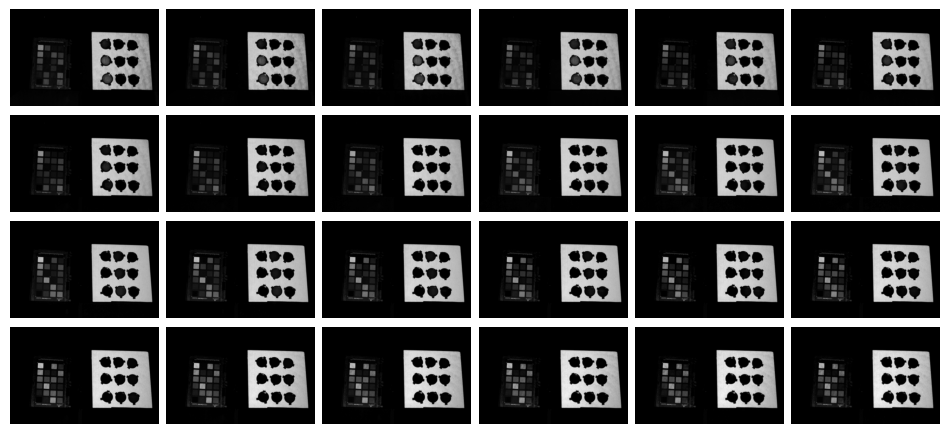

In [ ]:
# Set the dimensions of the grid
nrows = 4
ncols = 6

# Create a figure to hold the subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5.5),
                         subplot_kw={'xticks': [], 'yticks': []},
                         gridspec_kw={'hspace': 0.00, 'wspace': 0.05})


# Flatten the axes array for easy iteration
axes = axes.ravel()

for i in range(24):
    # Plot image on corresponding subplot
    axes[i].imshow((opt_param.detach().cpu().numpy().reshape(cam_H, cam_W, -1)[:,:,idx[i]]), cmap = 'gray')  # Use cmap='gray' if your images are grayscale
    # axes[i].imshow((opt_param_detach.reshape(cam_H, cam_W, -1)[:,:,i,np.newaxis] @ CRF[i][np.newaxis,:]))  # Use cmap='gray' if your images are grayscale

    axes[i].axis('off')  # Turn off axis

plt.tight_layout()
plt.show()

### RGB

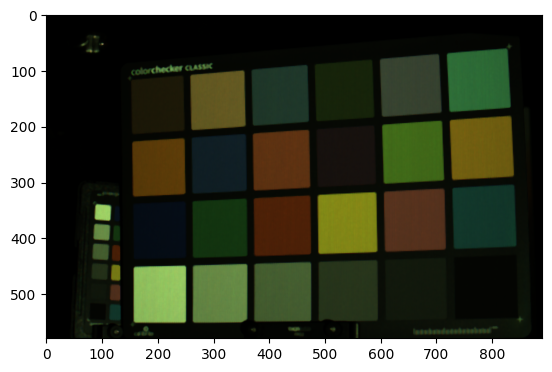

In [ ]:
np.save('./opt_param.npy', opt_param.detach().cpu().numpy().reshape(580, 890, 47))

rgb_img = (opt_param.detach().cpu().numpy().reshape(580, 890, 47))@CRF

plt.figure()
plt.imshow(rgb_img*0.02)
# plt.savefig('./rgb.png')

In [ ]:
efefef

NameError: name 'efefef' is not defined

### Figure Visualization

In [ ]:
# # DG efficiency for all pixels
# DG_efficiency_image_inv = np.zeros(shape=(cam_H * cam_W, len(new_wvls)))

# for i in range(cam_H * cam_W):
#     if zero_illum_idx[i] <= real_img_illum_idx_reshape[0,i]: # 430nm # -1 order
#         DG_efficiency_image_inv[i,:] =  DG_efficiency[0]
#     elif zero_illum_idx[i] > real_img_illum_idx_reshape[0,i]: # +1 order
#         DG_efficiency_image_inv[i,:] =  DG_efficiency[2]
#     else: # else
#         DG_efficiency_image_inv[i,:] = 0

In [ ]:
# pts2 = np.array([750,87])

# pts = np.array([645,370])

# fig, ax = plt.subplots()
# plt.ylim([0,1])
# plt.xlabel('wavelengh', fontsize=18)
# plt.ylabel('reflectance',fontsize=18)
# plt.ylim([0,1])
# plt.xlabel('wavelengths')
# plt.ylabel('reflectance')
# plt.plot(x_wvl, total_hyp_ref[pts[1],pts[0]], linestyle = '-', marker ='o', markersize = '4', color = 'red', label = 'nose')
# plt.plot(x_wvl, total_hyp_ref[pts2[1],pts2[0]], linestyle = '-', marker ='o', markersize = '4', color = 'blue', label= 'leaf')
# plt.grid(linestyle = '--')
# ax.tick_params(axis='both', which='major', labelsize=15)

# # plt.plot(ref_CC[:,i][:,np.newaxis] , label= 'GT')
# plt.legend(fontsize="13")
# # plt.title('%02d patch'%i)
# # plt.savefig('./%02d_patch.png'%i)

In [ ]:

# # for i in range(len(all_patches_center_pts)):
# fig, ax = plt.subplots()

# plt.ylim([0,1])
# plt.xlabel('wavelengh', fontsize=18)
# plt.ylabel('reflectance',fontsize=18)
# # plt.plot(x_wvl, total_hyp_ref[all_patches_center_pts[i,1],all_patches_center_pts[i,0]], label= 'Ours', linestyle = '-', marker ='o', markersize = '4', color = 'red')
# plt.plot(x_wvl, ref_CC[:,8][:,np.newaxis] , label= 'GT', linestyle = '-', marker ='o', markersize = '4', color = 'black')

# # plt.plot(x_wvl, total_hyp_ref[147,388], label= 'Ours left', linestyle = '-', marker ='o', markersize = '4', color = 'red')
# # plt.plot(x_wvl, total_hyp_ref[147,451], label= 'Ours right', linestyle = '-', marker ='o', markersize = '4', color = 'orange')

# for i in range(100):
        
#     plt.plot(x_wvl, total_hyp_ref[263,382], linestyle = '-', marker ='o', markersize = '4', color = 'red')
#     # plt.plot(x_wvl, total_hyp_ref[262,382 + i], linestyle = '-', marker ='o', markersize = '4', color = 'orange')

#     # plt.plot(x_wvl, total_hyp_ref[263,382], label= 'Ours left', linestyle = '-', marker ='o', markersize = '4', color = 'red')
#     # plt.plot(x_wvl, total_hyp_ref[262,460], label= 'Ours right', linestyle = '-', marker ='o', markersize = '4', color = 'orange')


# plt.legend(fontsize="13")
# plt.grid(linestyle = '--')
# ax.tick_params(axis='both', which='major', labelsize=15)
# plt.title('%02d patch'%i)

In [ ]:

# # for i in range(len(all_patches_center_pts)):
# fig, ax = plt.subplots()

# plt.ylim([0,1])
# plt.xlabel('wavelengh', fontsize=18)
# plt.ylabel('reflectance',fontsize=18)
# plt.plot(x_wvl, ref_CC[:,8][:,np.newaxis] , label= 'GT', linestyle = '-', marker ='o', markersize = '4', color = 'black')

# for i in range(100):
        
#     # plt.plot(x_wvl, total_hyp_ref[263,382], linestyle = '-', marker ='o', markersize = '4', color = 'red')
#     plt.plot(x_wvl, total_hyp_ref[262,382 + i], linestyle = '-', marker ='o', markersize = '4', color = 'orange')

#     # plt.plot(x_wvl, total_hyp_ref[263,382], label= 'Ours left', linestyle = '-', marker ='o', markersize = '4', color = 'red')
#     # plt.plot(x_wvl, total_hyp_ref[262,460], label= 'Ours right', linestyle = '-', marker ='o', markersize = '4', color = 'orange')


# plt.legend(fontsize="13")
# plt.grid(linestyle = '--')
# ax.tick_params(axis='both', which='major', labelsize=15)
# plt.title('%02d patch'%i)

In [ ]:

# # for i in range(len(all_patches_center_pts)):
# fig, ax = plt.subplots()

# plt.ylim([0,1])
# plt.xlabel('wavelengh', fontsize=18)
# plt.ylabel('reflectance',fontsize=18)
# plt.plot(x_wvl, ref_CC[:,8][:,np.newaxis] , label= 'GT', linestyle = '-', marker ='o', markersize = '4', color = 'black')

# for i in range(100):
        
#     # plt.plot(x_wvl, total_hyp_ref[263,382], linestyle = '-', marker ='o', markersize = '4', color = 'red')
#     plt.plot(x_wvl, total_hyp_ref[262,382 + i], linestyle = '-', marker ='o', markersize = '4', color = 'orange')

#     # plt.plot(x_wvl, total_hyp_ref[263,382], label= 'Ours left', linestyle = '-', marker ='o', markersize = '4', color = 'red')
#     # plt.plot(x_wvl, total_hyp_ref[262,460], label= 'Ours right', linestyle = '-', marker ='o', markersize = '4', color = 'orange')


# plt.legend(fontsize="13")
# plt.grid(linestyle = '--')
# ax.tick_params(axis='both', which='major', labelsize=15)
# plt.title('%02d patch'%i)